<h1>Turkiye EURO 2020 Analysis

The Turkish National Team qualified for the EURO 2020 tournament by losing only once in the group stage while also beating the world champions France once.

Everybody thought they were the dark horses, that they might just sneak in a win.

Turkiye finished dead last in their group, scoring only 1 goal and getting 0 points, so what went wrong?

In this analysis we will be delving into the data to figure out why Turkiye underachieved in EURO 2020 by looking at some key metrics.

<h4>Imports</h4>

In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mplsoccer as mpls
from mplsoccer import Pitch, VerticalPitch, FontManager
import matplotlib.ticker as ticker
from matplotlib import cm
from matplotlib.colors import ListedColormap

import matplotlib.patheffects as path_effects
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

import networkx as nx

In [100]:
df = pd.read_csv('datasets/euro2020data_combined.csv')

C:\Users\Aykut\AppData\Local\Temp\ipykernel_15284\505737534.py:1: DtypeWarning: Columns (17,69,74,75,81,85,89,90,91,100,102,103,104,105,106,107,108,110,111,112,113,114,115,118,119,120,121,122,123,124,125,126,127,128,129,131,132,133,134,135,136,137,138,139,140,141,142,143) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('datasets/euro2020data_combined.csv')


<h2>Data Handling

In [101]:
df.head()

,id,index,period,timestamp,minute,second,possession,duration,type_id,type_name,...,next_event,previous_event,next_team_possession,previous_team_possession,possession_retained,endloc_x,endloc_y,dist1,dist2,diffdist
0,2e4b1b7f-e67e-4bef-8cf1-2eab2ab81af2,1,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,Starting XI,NaN,Switzerland,NaN,1,NaN,NaN,NaN,NaN,NaN
1,f73c3f38-8c45-4802-8cb9-5a87234f385b,2,1,00:00:00.000,0,0,1,0.000000,35,Starting XI,...,Half Start,Starting XI,Switzerland,Switzerland,1,NaN,NaN,NaN,NaN,NaN
2,9098375d-3f07-4241-bdc9-3602a2e5c754,3,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,Half Start,Starting XI,Switzerland,Switzerland,1,NaN,NaN,NaN,NaN,NaN
3,18099197-a92a-4398-ac5e-39dad539c3eb,4,1,00:00:00.000,0,0,1,0.000000,18,Half Start,...,Pass,Half Start,Spain,Switzerland,0,NaN,NaN,NaN,NaN,NaN
4,ea57ee78-a4ef-4d62-81c7-98cdf1c11925,5,1,00:00:00.967,0,0,2,1.511008,30,Pass,...,Ball Receipt*,Half Start,Spain,Switzerland,1,35.2,33.3,59.000085,85.06427,-26.064185


In [102]:
df.shape

(192692, 174)

In [103]:
with pd.option_context('display.max_rows', 174, 'display.max_columns', None):
    print(df.dtypes)

id                                   object
index                                 int64
period                                int64
timestamp                            object
minute                                int64
second                                int64
possession                            int64
duration                            float64
type_id                               int64
type_name                            object
possession_team_id                    int64
possession_team_name                 object
play_pattern_id                       int64
play_pattern_name                    object
team_id                               int64
team_name                            object
tactics_formation                   float64
tactics_lineup                       object
related_events                       object
location                             object
player_id                           float64
player_name                          object
position_id                     

In [104]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192692 entries, 0 to 192691
Columns: 174 entries, id to diffdist
dtypes: float64(53), int64(12), object(109)
memory usage: 255.8+ MB


In [105]:
match_count = df['match_id'].nunique()
event_count = len(df)
shot_count =  len(df[(df['type_name'] == 'Shot')])
goal_count = len(df[(df['shot_outcome_name'] == 'Goal')])
pass_count = len(df[(df['type_name'] == 'Pass')])

print('Number of matches: ', match_count)
print('Number of events: ', event_count)
print('Number of shots: ', shot_count)
print('Number of goals: ', goal_count)
print('Number of passes: ', pass_count)


Number of matches:  51
Number of events:  192692
Number of shots:  1289
Number of goals:  155
Number of passes:  54819


In [106]:
type_counts = df['type_name'].value_counts()

# Display the type counts
print(type_counts)

Pass                 54819
Ball Receipt*        52721
Carry                43801
Pressure             15958
Ball Recovery         4445
Duel                  3355
Clearance             2283
Block                 1770
Goal Keeper           1514
Dribble               1476
Interception          1460
Foul Committed        1394
Foul Won              1337
Shot                  1289
Miscontrol            1273
Dispossessed          1087
Dribbled Past          894
Substitution           454
Injury Stoppage        288
Half Start             244
Half End               244
Tactical Shift         125
Referee Ball-Drop      121
Starting XI            102
Shield                  58
50/50                   56
Bad Behaviour           26
Error                   24
Player Off              22
Player On               21
Own Goal Against        11
Own Goal For            11
Offside                  9
Name: type_name, dtype: int64


<h5> Creating functions and dataframes for later use

In [107]:
turkey_matches = df.loc[df['team_name'] == 'Turkey', ['match_id', 'home_team_name', 'away_team_name']].drop_duplicates().reset_index(drop=True)
matchids = turkey_matches['match_id'].tolist()
matchids

[3788755, 3788741, 3788765]

In [108]:
forxg = df[(df['type_name'] == 'Shot') & (df['match_id'].isin(matchids))]
forxg = forxg[["match_id",'minute', 'team_name', 'shot_statsbomb_xg', 'shot_outcome_name', 'location']]
forxg['location_x'] = forxg['location'].str.split(',', expand=True)[0].str.strip()
forxg['location_y'] = forxg['location'].str.split(',', expand=True)[1].str.strip()
forxg['location_x'] = pd.to_numeric(forxg['location_x'], errors='coerce')
forxg['location_y'] = pd.to_numeric(forxg['location_y'], errors='coerce')
forxg['shot_statsbomb_xg'] = pd.to_numeric(forxg['shot_statsbomb_xg'], errors='coerce')

forxg = forxg.drop('location', axis=1)
forxg.groupby("match_id")
forxg.sort_values(by=['match_id', 'minute'], inplace=True)
forxg.reset_index(drop=True, inplace=True)

forxg

,match_id,minute,team_name,shot_statsbomb_xg,shot_outcome_name,location_x,location_y
0,3788741,2,Italy,0.052236,Off T,114.6,50.1
1,3788741,13,Italy,0.009444,Blocked,98.9,58.7
2,3788741,17,Italy,0.098552,Off T,108.2,27.3
3,3788741,19,Italy,0.006578,Off T,87.0,53.6
4,3788741,20,Italy,0.051247,Blocked,97.1,44.3
...,...,...,...,...,...,...,...
99,3788765,79,Switzerland,0.064403,Blocked,104.4,44.1
100,3788765,82,Turkey,0.034126,Blocked,96.9,51.1
101,3788765,82,Turkey,0.204877,Off T,113.4,41.1
102,3788765,88,Turkey,0.146092,Saved,108.4,37.1


In [109]:
shot_count_by_match = forxg.groupby(['match_id', 'team_name']).size().reset_index(name='shot_count')
shot_count_by_match

,match_id,team_name,shot_count
0,3788741,Italy,24
1,3788741,Turkey,3
2,3788755,Turkey,18
3,3788755,Wales,16
4,3788765,Switzerland,23
5,3788765,Turkey,20


In [110]:
fordisp=df[(df['type_name'] == 'Dispossessed') & (df['match_id'].isin(matchids))]
fordisp = fordisp[["match_id",'team_name', 'type_name']].reset_index(drop=True)
disp_count_by_match = fordisp.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
disp_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,7
1,3788741,Turkey,6
2,3788755,Turkey,8
3,3788755,Wales,6
4,3788765,Switzerland,15
5,3788765,Turkey,10


In [111]:
formiscontrol=df[(df['type_name'] == 'Miscontrol') & (df['match_id'].isin(matchids))]
formiscontrol = formiscontrol[["match_id",'team_name', 'type_name']].reset_index(drop=True)
miscontrol_count_by_match = fordisp.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
miscontrol_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,7
1,3788741,Turkey,6
2,3788755,Turkey,8
3,3788755,Wales,6
4,3788765,Switzerland,15
5,3788765,Turkey,10


In [112]:
posdata = df.groupby(['match_id', 'possession_team_name'])['duration'].sum().reset_index(name='total_duration')
posdata['possession_percentage'] = posdata.groupby('match_id')['total_duration'].transform(lambda x: x / x.sum() * 100)
possession_per_match = posdata[posdata['match_id'].isin(matchids)].reset_index(drop=True)
possession_per_match = possession_per_match.rename(columns={'possession_team_name': 'team_name'})
possession_per_match

,match_id,team_name,total_duration,possession_percentage
0,3788741,Italy,2224.722585,66.517099
1,3788741,Turkey,1119.864937,33.482901
2,3788755,Turkey,1868.413592,62.146837
3,3788755,Wales,1138.036422,37.853163
4,3788765,Switzerland,1707.254901,50.917371
5,3788765,Turkey,1645.736150,49.082629


In [113]:
forpress=df[(df['type_name'] == 'Pressure') & (df['match_id'].isin(matchids))]
forpress = forpress[["match_id",'team_name', 'type_name', 'location']].reset_index(drop=True)
forpress['location_x'] = forpress['location'].str.split(',', expand=True)[0].str.strip()
forpress['location_y'] = forpress['location'].str.split(',', expand=True)[1].str.strip()
forpress['location_x'] = pd.to_numeric(forpress['location_x'], errors='coerce')
forpress['location_y'] = pd.to_numeric(forpress['location_y'], errors='coerce')
forpress = forpress.drop('location', axis=1)
forpress

,match_id,team_name,type_name,location_x,location_y
0,3788755,Turkey,Pressure,26.1,56.7
1,3788755,Turkey,Pressure,33.6,53.0
2,3788755,Turkey,Pressure,23.0,49.0
3,3788755,Wales,Pressure,90.8,26.2
4,3788755,Wales,Pressure,82.1,9.4
...,...,...,...,...,...
1069,3788765,Switzerland,Pressure,27.4,24.9
1070,3788765,Switzerland,Pressure,23.9,21.8
1071,3788765,Switzerland,Pressure,16.0,36.6
1072,3788765,Switzerland,Pressure,27.9,49.3


In [114]:
press_count_by_match = forpress.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
press_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,161
1,3788741,Turkey,221
2,3788755,Turkey,160
3,3788755,Wales,158
4,3788765,Switzerland,174
5,3788765,Turkey,200


In [115]:
forcntrprs = df[df['match_id'].isin(matchids) & (df['counterpress'] == True)]
forcntrprs = forcntrprs[["match_id",'team_name','counterpress', 'location']]
forcntrprs.groupby("match_id")
forcntrprs.sort_values(by=['match_id'], inplace=True)
forcntrprs.reset_index(drop=True, inplace=True)
forcntrprs['location_x'] = forcntrprs['location'].str.split(',', expand=True)[0].str.strip()
forcntrprs['location_y'] = forcntrprs['location'].str.split(',', expand=True)[1].str.strip()
forcntrprs['location_x'] = pd.to_numeric(forcntrprs['location_x'], errors='coerce')
forcntrprs['location_y'] = pd.to_numeric(forcntrprs['location_y'], errors='coerce')
forcntrprs = forcntrprs.drop('location', axis=1)
forcntrprs

,match_id,team_name,counterpress,location_x,location_y
0,3788741,Italy,True,49.8,2.7
1,3788741,Italy,True,60.2,76.8
2,3788741,Italy,True,52.8,74.1
3,3788741,Italy,True,74.4,4.1
4,3788741,Italy,True,75.9,8.6
...,...,...,...,...,...
337,3788765,Turkey,True,79.5,4.4
338,3788765,Turkey,True,76.9,4.4
339,3788765,Turkey,True,77.7,5.7
340,3788765,Switzerland,True,36.4,17.7


In [116]:
counterpress_count_by_match = forcntrprs.groupby(['match_id', 'team_name']).size().reset_index(name='counterpress')
counterpress_count_by_match

,match_id,team_name,counterpress
0,3788741,Italy,76
1,3788741,Turkey,51
2,3788755,Turkey,45
3,3788755,Wales,42
4,3788765,Switzerland,62
5,3788765,Turkey,66


In [117]:
interception_outcomes = ['Won', 'Success In Play', 'Success out']
forint = df[(df['interception_outcome_name'].isin(interception_outcomes)) & (df['match_id'].isin(matchids))]
forint = forint[["match_id",'team_name', 'type_name']].reset_index(drop=True)
interception_count_by_match = forint.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
interception_count_by_match

,match_id,team_name,type_name
0,3788741,Italy,15
1,3788741,Turkey,15
2,3788755,Turkey,5
3,3788755,Wales,10
4,3788765,Switzerland,10
5,3788765,Turkey,10


In [118]:
# testing = df['duel_outcome_name'].value_counts()
# testing

forduel = df[(df['type_name'] == 'Duel') & (df['match_id'].isin(matchids))]

# forduel['duel_result'] = np.where(df['duel_outcome_name'].isin(['Success In Play', 'Won', 'Success Out']), 'WON', 'LOST')

forduel['duels_won'] = df['duel_outcome_name'].isin(['Success In Play', 'Won', 'Success Out']).astype(int)
forduel['duels_lost'] = df['duel_outcome_name'].isin(['Lost In Play', 'Lost Out']).astype(int)

forduel = forduel[['match_id', 'team_name', 'player_name', 'duels_won', 'duels_lost']].reset_index(drop=True)
duel_per_player = forduel.groupby(['match_id', 'player_name']).agg({'duels_won': 'sum', 'duels_lost': 'sum'}).reset_index()
duel_per_player

# forduel
# player_stats = forduel[(forduel['player_name'] == 'Cengiz Umut Meraş') & (forduel['match_id'] == 3788741)]
# print(player_stats)


C:\Users\Aykut\AppData\Local\Temp\ipykernel_15284\4150178657.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forduel['duels_won'] = df['duel_outcome_name'].isin(['Success In Play', 'Won', 'Success Out']).astype(int)
C:\Users\Aykut\AppData\Local\Temp\ipykernel_15284\4150178657.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  forduel['duels_lost'] = df['duel_outcome_name'].isin(['Lost In Play', 'Lost Out']).astype(int)


,match_id,player_name,duels_won,duels_lost
0,3788741,Burak Yılmaz,0,0
1,3788741,Cengiz Umut Meraş,0,1
2,3788741,Cengiz Ünder,0,1
3,3788741,Ciro Immobile,0,0
4,3788741,Domenico Berardi,0,0
...,...,...,...,...
62,3788765,Ruben Vargas,1,0
63,3788765,Silvan Widmer,0,1
64,3788765,Xherdan Shaqiri,0,1
65,3788765,Yusuf Yazıcı,0,0


In [119]:
duel_per_player['duel_percentage'] = duel_per_player['duels_won'] / (duel_per_player['duels_won'] + duel_per_player['duels_lost'])
duel_per_player.dropna(inplace=True)
duel_per_player.head()

,match_id,player_name,duels_won,duels_lost,duel_percentage
1,3788741,Cengiz Umut Meraş,0,1,0.0
2,3788741,Cengiz Ünder,0,1,0.0
5,3788741,Giorgio Chiellini,1,0,1.0
6,3788741,Giovanni Di Lorenzo,1,0,1.0
7,3788741,Hakan Çalhanoğlu,1,0,1.0


In [188]:
ball_recoveries = ['Dispossessed', 'Interception', 'Miscontrol']
ball_loss = df[df['type_name'].isin(ball_recoveries) & df['match_id'].isin(matchids)]
ball_loss = ball_loss[['match_id', 'location', 'team_name', 'type_name']].reset_index(drop=True)

# Assigning the "interception" value to the other team

interceptions = ball_loss[ball_loss['type_name'] == 'Interception']
for _, interception in interceptions.iterrows():
    other_team = ball_loss[
        (ball_loss['match_id'] == interception['match_id']) &
        (ball_loss['team_name'] != interception['team_name'])
    ]
    ball_loss.loc[interception.name, 'team_name'] = other_team['team_name'].iloc[0]

ball_loss['location_x'] = ball_loss['location'].str.split(',', expand=True)[0].str.strip()
ball_loss['location_y'] = ball_loss['location'].str.split(',', expand=True)[1].str.strip()
ball_loss['location_x'] = pd.to_numeric(ball_loss['location_x'], errors='coerce')
ball_loss['location_y'] = pd.to_numeric(ball_loss['location_y'], errors='coerce')
ball_loss = ball_loss.drop('location', axis=1)

ball_loss
# interceptions1 = ball_loss[ball_loss['type_name'] == 'Interception']
# interceptions1

,match_id,team_name,type_name,location_x,location_y
0,3788755,Turkey,Miscontrol,23.1,65.3
1,3788755,Wales,Miscontrol,91.6,34.4
2,3788755,Wales,Miscontrol,39.4,16.2
3,3788755,Wales,Dispossessed,112.7,77.6
4,3788755,Turkey,Dispossessed,104.6,29.9
...,...,...,...,...,...
222,3788765,Switzerland,Miscontrol,106.6,34.8
223,3788765,Turkey,Interception,24.1,29.6
224,3788765,Turkey,Interception,31.7,29.6
225,3788765,Switzerland,Dispossessed,32.3,29.6


In [121]:
forpass=df[(df['type_name'] == 'Pass') & (df['match_id'].isin(matchids))]
forpass = forpass[["match_id",'team_name', 'type_name', 'location', "player_id", "pass_recipient_id", "pass_end_location_x", "pass_end_location_y", "pass_outcome_name"]].reset_index(drop=True)
forpass['location_x'] = forpass['location'].str.split(',', expand=True)[0].str.strip()
forpass['location_y'] = forpass['location'].str.split(',', expand=True)[1].str.strip()
forpass['location_x'] = pd.to_numeric(forpass['location_x'], errors='coerce')
forpass['location_y'] = pd.to_numeric(forpass['location_y'], errors='coerce')
forpass = forpass.drop('location', axis=1)
forpass

,match_id,team_name,type_name,player_id,pass_recipient_id,pass_end_location_x,pass_end_location_y,pass_outcome_name,location_x,location_y
0,3788755,Wales,Pass,3517.0,4767.0,36.4,28.6,NaN,61.0,40.1
1,3788755,Wales,Pass,4767.0,3853.0,86.5,0.2,Out,36.1,29.7
2,3788755,Turkey,Pass,10349.0,12293.0,17.4,67.8,NaN,34.4,80.0
3,3788755,Turkey,Pass,12293.0,10349.0,16.5,74.3,NaN,17.4,67.8
4,3788755,Turkey,Pass,10349.0,12555.0,22.8,66.3,NaN,18.0,75.2
...,...,...,...,...,...,...,...,...,...,...
2983,3788765,Turkey,Pass,12555.0,10826.0,108.1,17.4,NaN,96.2,31.9
2984,3788765,Turkey,Pass,10826.0,NaN,112.8,22.6,Incomplete,113.4,19.1
2985,3788765,Turkey,Pass,10826.0,29989.0,118.3,7.8,NaN,120.0,0.1
2986,3788765,Turkey,Pass,29989.0,8541.0,111.1,39.4,NaN,118.3,7.8


In [122]:
forthru=df[(df['pass_technique_name'] == 'Through Ball') & (df['match_id'].isin(matchids))]
forthru = forthru[["match_id",'team_name', 'pass_technique_name', 'location', "player_id", "pass_recipient_id", "pass_end_location_x", "pass_end_location_y", "pass_outcome_name"]].reset_index(drop=True)
forthru['location_x'] = forthru['location'].str.split(',', expand=True)[0].str.strip()
forthru['location_y'] = forthru['location'].str.split(',', expand=True)[1].str.strip()
forthru['location_x'] = pd.to_numeric(forthru['location_x'], errors='coerce')
forthru['location_y'] = pd.to_numeric(forthru['location_y'], errors='coerce')
forthru = forthru.drop('location', axis=1)
forthru.head()

,match_id,team_name,pass_technique_name,player_id,pass_recipient_id,pass_end_location_x,pass_end_location_y,pass_outcome_name,location_x,location_y
0,3788755,Turkey,Through Ball,10349.0,11086.0,88.7,62.5,NaN,33.6,74.6
1,3788755,Wales,Through Ball,6399.0,3517.0,110.4,28.0,NaN,87.0,18.6
2,3788755,Wales,Through Ball,6399.0,3517.0,106.8,44.8,NaN,84.0,59.9
3,3788755,Wales,Through Ball,6399.0,3517.0,109.4,42.3,NaN,71.9,66.8
4,3788755,Turkey,Through Ball,8963.0,6971.0,120.0,25.8,Out,62.7,12.4


In [123]:
thruball_per_match = forthru.groupby(['match_id', 'team_name']).size().reset_index(name='type_name')
thruball_per_match

,match_id,team_name,type_name
0,3788741,Italy,11
1,3788741,Turkey,6
2,3788755,Turkey,3
3,3788755,Wales,3
4,3788765,Switzerland,5
5,3788765,Turkey,1


In [124]:
fordrbpast=df[(df['type_name'] == 'Dribbled Past') & (df['match_id'].isin(matchids))]
fordrbpast = fordrbpast[["match_id",'team_name', "player_name"]].reset_index(drop=True)
fordrbpast

,match_id,team_name,player_name
0,3788755,Wales,Kieffer Roberto Francisco Moore
1,3788755,Turkey,Mehmet Zeki Çelik
2,3788755,Turkey,Caglar Söyüncü
3,3788755,Turkey,Mehmet Zeki Çelik
4,3788755,Turkey,Burak Yılmaz
...,...,...,...
57,3788765,Turkey,Okay Yokuşlu
58,3788765,Switzerland,Ruben Vargas
59,3788765,Switzerland,Silvan Widmer
60,3788765,Turkey,Burak Yılmaz


In [125]:
drbpast_per_player = fordrbpast.groupby(['match_id', 'player_name']).size().reset_index(name='type_name')
drbpast_per_player.head()

,match_id,player_name,type_name
0,3788741,Burak Yılmaz,1
1,3788741,Caglar Söyüncü,1
2,3788741,Cengiz Umut Meraş,1
3,3788741,Ciro Immobile,1
4,3788741,Domenico Berardi,2


In [126]:
'''
playercount = df['player_name'].nunique() WE HAVE 490 PLAYERS IN TOTAL SO OBV ROW COUNT SHOULD BE 490
playercount

player_obv = df.groupby('player_name')['obv_total_net'].sum().reset_index()
player_obv['obv_per90'] = player_obv['obv_total_net'] / 90

player_obv
'''

"\nplayercount = df['player_name'].nunique() WE HAVE 490 PLAYERS IN TOTAL SO OBV ROW COUNT SHOULD BE 490\nplayercount\n\nplayer_obv = df.groupby('player_name')['obv_total_net'].sum().reset_index()\nplayer_obv['obv_per90'] = player_obv['obv_total_net'] / 90\n\nplayer_obv\n"

In [166]:
def plot_xg_race(dataframe, matchid, team1, team2):

    match = forxg[forxg['match_id'] == matchid]
    match.sort_values(by='minute', inplace=True)
    
    teams = match['team_name'].unique()

    fig, ax = plt.subplots(figsize=(12, 6))  # Adjust figure size
    colors = ['blue', 'red', 'green', 'orange']
    
    cumulative_xg = {team: [] for team in teams}
    step_minutes = {team: [] for team in teams}
    step_xg = {team: [] for team in teams}
    
    # Iterating over each minute in the match
    for minute in match['minute']:
        for team in teams:
            # Calculating the cumulative xG for the current minute and team
            cumulative_xg[team].append(match[(match['team_name'] == team) & (match['minute'] <= minute)]['shot_statsbomb_xg'].sum())
        
        # Check if the xG value increased in the last minute
        for team in teams:
            if len(cumulative_xg[team]) > 1 and cumulative_xg[team][-1] > cumulative_xg[team][-2]:
                step_minutes[team].append(minute)
                step_xg[team].append(cumulative_xg[team][-2])
    
    # Ploting xG lines
    for i, team in enumerate(teams):
        ax.step(match['minute'], cumulative_xg[team], label=team, color=colors[i], where='post', linestyle='-')
    
    # Plotting the steps
    for team in teams:
        ax.scatter(step_minutes[team], step_xg[team], color=colors[i], marker='o', s=15)
    
    goals = match[match['shot_outcome_name'] == 'Goal']
    y_values = [cumulative_xg[team][j] for team, j in zip(goals['team_name'], goals.index)]
    ax.scatter(goals['minute'], y_values, color='red', marker='*', s=200, label='Goal', zorder=3, alpha=0.7)

    ax.set_xticks(range(0, max(match['minute'])+1, 10))  # Adjust tick frequency
    
    ax.set_xlabel('Minute')
    ax.set_ylabel('Cumulative xG')
    ax.legend()
    ax.set_title(f'xG Race - {team1} ({cumulative_xg[team1][-1]:.2f}) vs {team2} ({cumulative_xg[team2][-1]:.2f})')
    plt.show()



In [128]:
def plot_bar(id, dataframe, type, plotname):
    selected_match = dataframe[dataframe['match_id'] == id]

    team_names = selected_match['team_name'].unique()
    # Print the team names
    for team in team_names:
        team1 = team_names[0]
        team2 = team_names[1]


    plt.bar(selected_match['team_name'], selected_match[type])
    plt.xlabel('Team')
    plt.ylabel(plotname)
    plt.title(f'{plotname} - {team1} vs {team2}')

    for i, count in enumerate(selected_match[type]):
        plt.text(i, count, f'{count:.2f}' if count % 1 != 0 else f'{count:.0f}', ha='center', va='bottom')


    plt.show()

In [129]:
def heatmap_gaussian(id, dataframe, team, didthis):   
    
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
    
    pitch = Pitch(pitch_type='statsbomb', line_zorder=2, pitch_color='#22312b', line_color='#efefef')
    fig, ax = pitch.draw(figsize=(6.6, 4.125))
    fig.set_facecolor('#22312b')
    
    bin_statistic = pitch.bin_statistic(plotter['location_x'], plotter['location_y'], statistic='count', bins=(25, 25))
    bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], 1)
    pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='hot', edgecolors='#22312b')
    
    # Add the colorbar and format off-white
    cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)
    cbar.outline.set_edgecolor('#efefef')
    cbar.ax.yaxis.set_tick_params(color='#efefef')
    
    ax.set_title(f'Areas where {team} { didthis}', color='#efefef', fontsize=14)

In [130]:
def shotmap(id, dataframe, team):   
    
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
    
    pitch = VerticalPitch(pad_bottom=0.5,
                      half=True,  
                      goal_type='box',
                      goal_alpha=0.8)  
    fig, ax = pitch.draw(figsize=(8, 5))

    sc1 = pitch.scatter(plotter[plotter['shot_outcome_name'] == 'Goal']['location_x'], plotter[plotter['shot_outcome_name'] == 'Goal']['location_y'],
                    s=100,
                    c='#b94b75', 
                    edgecolors='#383838',  
                    marker='o',  # Use 'o' marker shape for goals
                    ax=ax)
    
    sc2 = pitch.scatter(plotter[plotter['shot_outcome_name'] != 'Goal']['location_x'], plotter[plotter['shot_outcome_name'] != 'Goal']['location_y'],
                    s=(plotter[plotter['shot_outcome_name'] != 'Goal']['shot_statsbomb_xg'] * 900) + 100,
                    c='#b94b75', 
                    edgecolors='#383838',  
                    marker=(5, 2),  # Use (5, 2) marker shape for non-goals
                    ax=ax)
    txt = ax.text(x=40, y=80, s=f'{team} shots',
                size=30,
                color=pitch.line_color,
                va='center', ha='center')

In [131]:
def passflow_map(id, dataframe, team, team2):
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
        
    columns = ['location_x', 'location_y', 'pass_end_location_x', 'pass_end_location_y', 'pass_outcome_name']
    
    plotter_pass = plotter[columns]

    pitch = Pitch(pitch_type='statsbomb',  line_zorder=2, line_color='#c7d5cc', pitch_color='#22312b')
    bins = (10, 6)
    
    fig, ax = pitch.draw(figsize=(8, 5), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')
    
    bs_heatmap = pitch.bin_statistic(plotter_pass.location_x, plotter_pass.location_y, statistic='count', bins=bins)
    hm = pitch.heatmap(bs_heatmap, ax=ax, cmap='Greens')
    
    fm = pitch.flow(plotter_pass.location_x, plotter_pass.location_y, plotter_pass.pass_end_location_x, plotter_pass.pass_end_location_y, color='black',
                    arrow_type='average', bins=bins, ax=ax)
    ax_title = ax.set_title(f'{team} pass flow map vs {team2}', fontsize=20, pad=-20, color='#efefef')



In [132]:
def thruball_map(id, dataframe, team, team2):
    plotter = dataframe[(dataframe['match_id'] == id) & (dataframe['team_name'] == team)]
        
    columns = ['location_x', 'location_y', 'pass_end_location_x', 'pass_end_location_y', 'pass_outcome_name']
    
    plotter_pass = plotter[columns]

    pitch = Pitch(pitch_type='statsbomb', pitch_color='#22312b', line_color='#c7d5cc')
    fig, ax = pitch.draw(figsize=(8, 5), constrained_layout=True, tight_layout=False)
    fig.set_facecolor('#22312b')

    # Plot the through balls
    pitch.arrows(plotter_pass.location_x, plotter_pass.location_y, plotter_pass.pass_end_location_x, plotter_pass.pass_end_location_y, width=2,
                headwidth=10, headlength=10, color='#ad993c', ax=ax, label='Through balls')

    ax_title = ax.set_title(f'{team} through balls vs {team2}', fontsize=20, color='#efefef')


In [133]:
def compare_players_plot(id, dataframe, type, plotname, truefalse):
    selected_match = dataframe[dataframe['match_id'] == id]

    bars = plt.barh(selected_match['player_name'], selected_match[type].sort_values(ascending=truefalse))
    plt.xlabel(plotname)
    plt.ylabel('Player Name')
    plt.title(f'{plotname}')
    plt.xticks(range(0, int(max(selected_match[type])) + 1, 1))


    for bar in bars:
        width = bar.get_width()
        y = bar.get_y()
        plt.text(width+0.030, y+0.4, f'{width:.2f}' if width % 1 != 0 else f'{width:.0f}', ha='center', va='center')
        
    plt.show()

<h2> Match Analysis

<h4> <b>Thoughts before analysis</b>

Before delving into the data, I'd like to express some of my own thoughts on the way the Turkish national team played in the group stages of EURO 2020.

<h5> <b>Pre-tournament expectations</b> </h5>

1. The Turkish national team qualified for the competition only losing once, to Iceland.
2. The Turkish national team beat and drew with the reigning world champions France during the qualifying stage.
3. The Turkish national team conceded only 3 goals, 3 less than France who are considered an extremely defensive team.
4. The Turkish national team were considered dark horses (a team expected to overachieve while being discrete doing so) by many pundits and people on social media.
5. The Turkish national team was hyped by the Turkish people, and were tipped to win it all. A mistake which we will touch on later.

<h5> <b>The group stage</b> </h5>

I believe the performance of the Turkish national team could be summed up in a few points:

1. The team seemed to crack under the pressure and played with shaky legs.
2. The mental drop turned into simple mistakes, misplaced passes, low % in duels, a collective loss of cohesion.
3. The team seemed to lack a tactical understanding, something that was pointed out by a minority during the qualifying stages.
4. Player positioning was off, once again displaying how the Turkish national team was getting crushed under mental pressure.
5. Running distance and pressures seemed to lack, lost balls weren't being chased after, causing the opposing teams to assert dominance on the field.
6. Coaching staff didn't seem to have a grip on the situation, making it worse for the men in red and white.

These few points should be enough for now, let's see if the stats back these points up.

<h4> Delving into the stats

<h4> <b>Italy 3 - 0 Turkiye</b> </h4>

<b>Turkiye Squad:</b>

Uğurcan Çakır - GK

Zeki Çelik - RB

Merih Demiral - CB

Çağlar Söyüncü - CB

Umut Meraş - LB

Okay Yokuşlu - CDM

Kenan Karaman - RM

Ozan Tufan - CM

Yusuf Yazıcı - CM

Hakan Çalhanoğlu - LM

Burak Yılmaz - ST

<h5> <b> Possession


In [134]:
tvi_id = 3788741

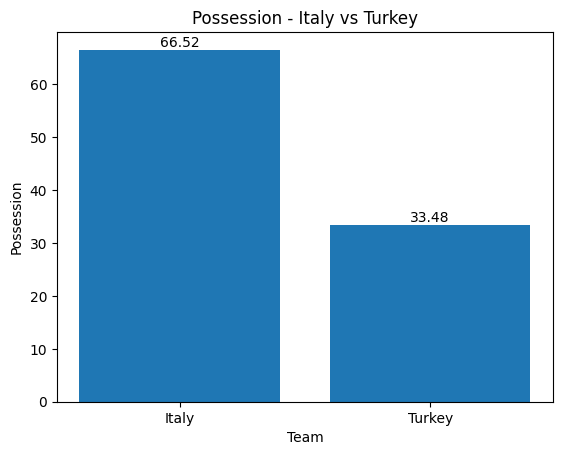

In [135]:
plot_bar(tvi_id, possession_per_match, 'possession_percentage', 'Possession')

The Turks were dominated on the ball, keeping only around 33.5% of the ball during the whole match.

<h5> <b> xG Chart & Shots


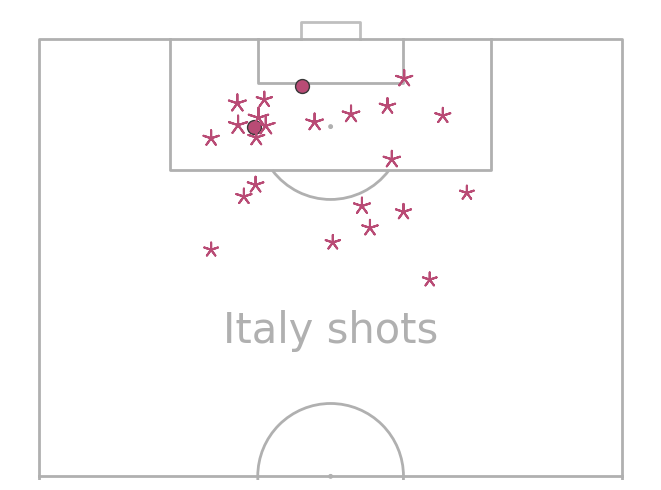

In [136]:
shotmap(tvi_id, forxg, 'Italy')

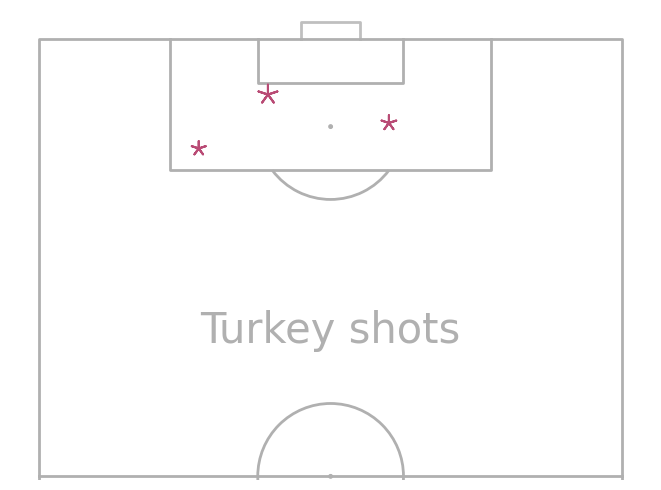

In [137]:
shotmap(tvi_id, forxg, 'Turkey')

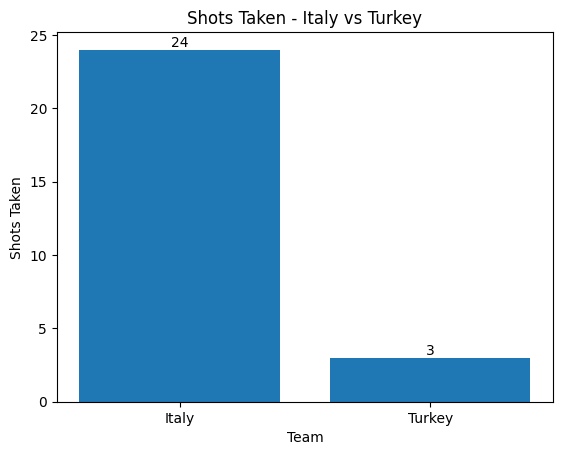

In [138]:
plot_bar(tvi_id, shot_count_by_match, 'shot_count', "Shots Taken")

C:\Users\Aykut\AppData\Local\Temp\ipykernel_15284\102367086.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  match.sort_values(by='minute', inplace=True)


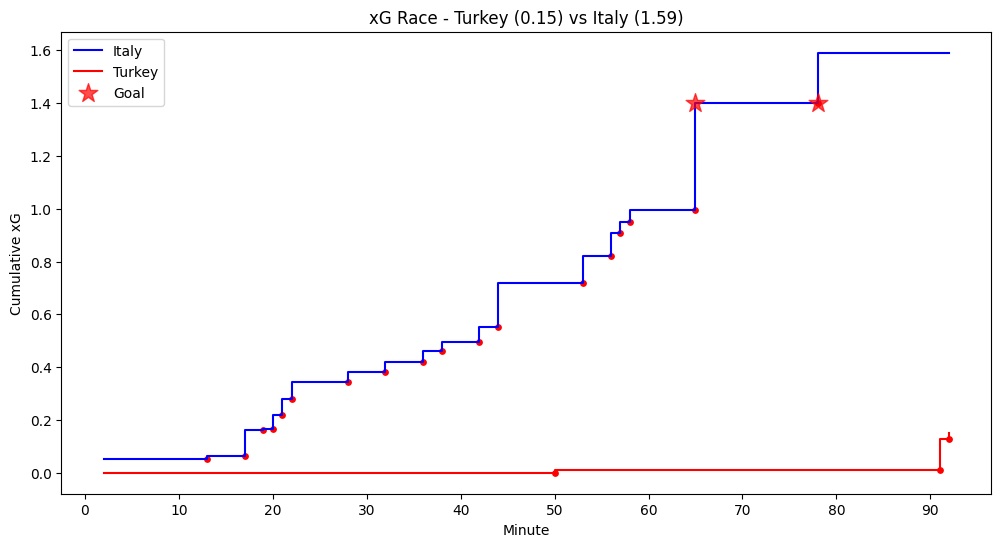

In [164]:
# plot_xg_race(forxg, tvi_id, 'Turkey', 'Italy')

As seen on the xG race chart, Turkiye conceded 3 goals (with 1 own goal, 24 shots) on around 1.6 xG while producing only around 0.15 xG (3 shots). Turkiye were able to produce their only semi-noteworthy xG in injury time of the second half.

<h5> <b> Dispossession


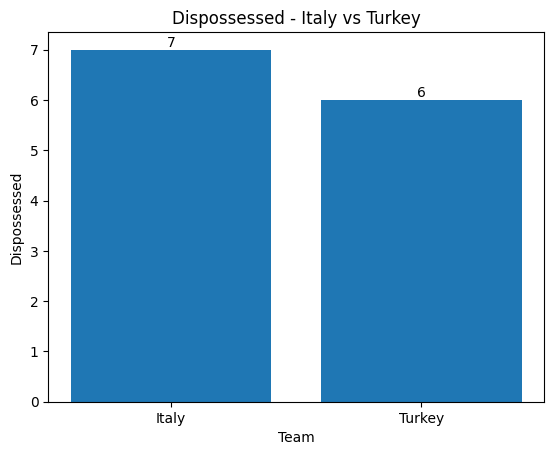

In [140]:
plot_bar(tvi_id, disp_count_by_match, 'type_name', "Dispossessed")

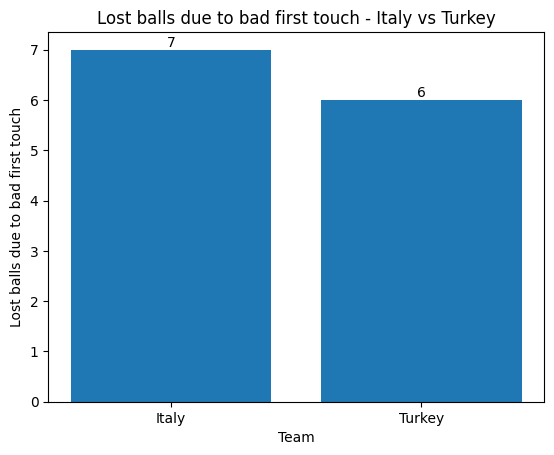

In [141]:
plot_bar(tvi_id, miscontrol_count_by_match, 'type_name', "Lost balls due to bad first touch")

Contrary to my predictions from before, Turkiye was not dispossessed much more than Italy. In fact, the Italians would start their winning campaign by losing the ball more than their opponents.

<h5> <b> Pressures made


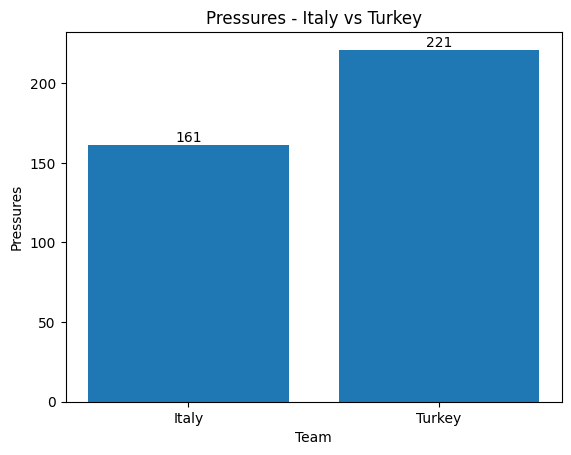

In [142]:
plot_bar(tvi_id, press_count_by_match, 'type_name', "Pressures")

Interestingly, the Turkish team pressed the Italians almost 40% more, proving my point on "lack of pressures" wrong. We should also look at counterpress', where a team presses back within 5 seconds of an open play turnover.

<h5> <b> Counterpresses


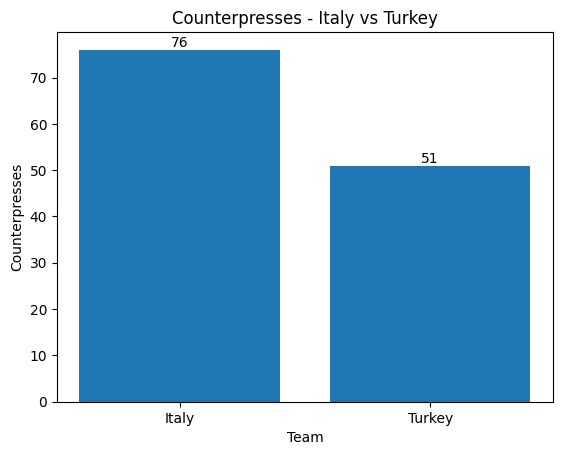

In [143]:
plot_bar(tvi_id, counterpress_count_by_match, 'counterpress', "Counterpresses")

As seen here, the Turkish national team were out-counterpressed. This means that the Turks only pressed back 51 times to get a ball they lost, while the Italians pressed 76 times. The lack of heart from the Turkish team seems to have been their demise here. Let's check out the interceptions.

<h5> <b> Interceptions


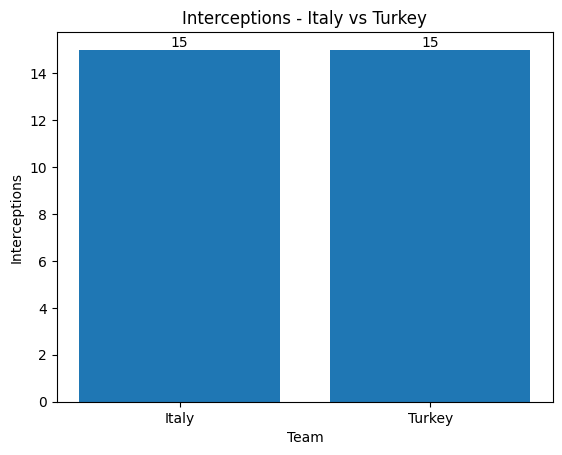

In [144]:
plot_bar(tvi_id, interception_count_by_match, 'type_name', "Interceptions")

Interceptions seem to be equal. Maybe the Turks had trouble gaining the ball and pressing in the *right* places of the pitch. Let's take a look at the zones of possession gain for both teams.

<h5> <b> Zones of Ball Loss


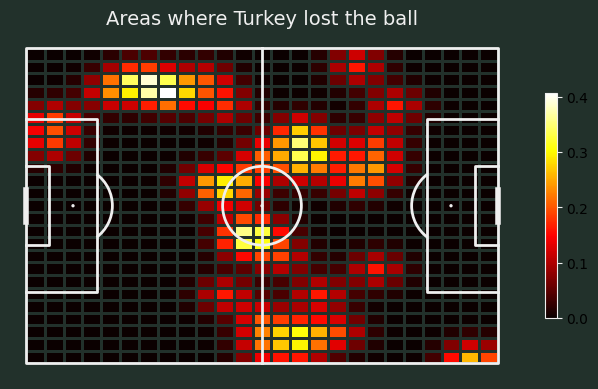

In [145]:
heatmap_gaussian(tvi_id, ball_loss, 'Turkey', 'lost the ball')

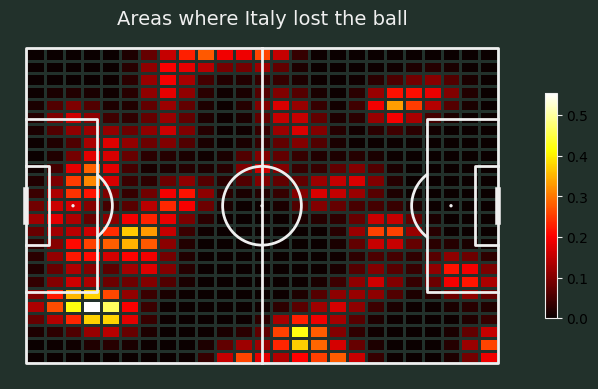

In [146]:
heatmap_gaussian(tvi_id, ball_loss, 'Italy', 'lost the ball')

I realised that area of ball loss may be distorted as attacking direction changes after half time, but after some research, I've learned that football data is orientated so the attack direction is from left to right. I'm not 100% confident of this fact, but I will take it for now.

As seen on the heatmaps, while the Italians have generally lost the ball all around the pitch, the Turks have mainly lost it in the middle of the pitch and around the left back position. (Umut Meras was the left back for Turkiye.)

The areas of loss indicate that the Italian midfield overrun the Turkish midfield and was able to go on to attack straight away. 

Let's see if the zones of pressing and counterpressing correlate with the possession loss heatmap.

<h5> <b> Zones of Press & Counterpress

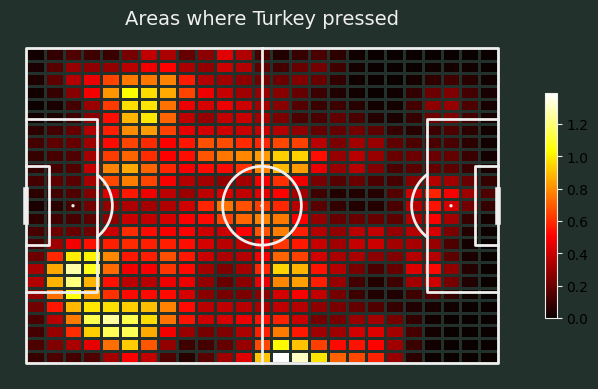

In [147]:
heatmap_gaussian(tvi_id, forpress, 'Turkey', 'pressed')

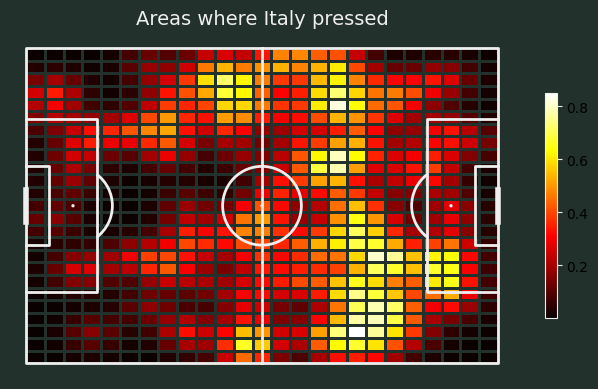

In [148]:
heatmap_gaussian(tvi_id, forpress, 'Italy', 'pressed')

A very interesting graph is upon us. Turkiye seem to have pressed mostly in their own half while Italy have pressed mostly between the Turkish defence and midfield lines. This implies that Turkey were under high pressure starting from the goalkeeper, while they could only press back to get the ball from an attacking Italy side.

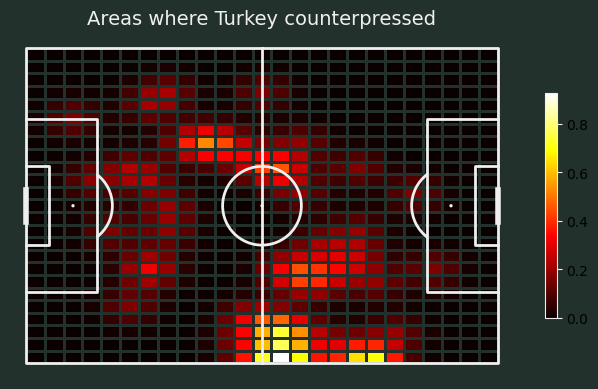

In [149]:
heatmap_gaussian(tvi_id, forcntrprs, 'Turkey', 'counterpressed')

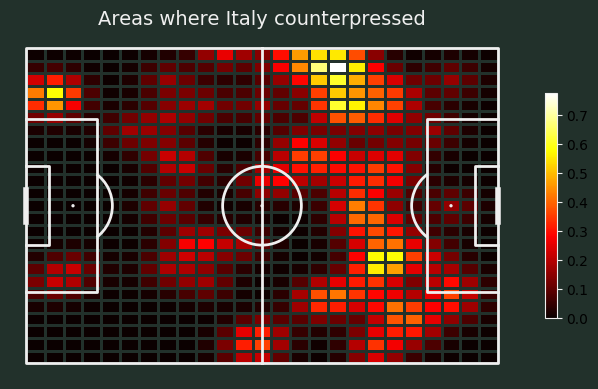

In [150]:
heatmap_gaussian(tvi_id, forcntrprs, 'Italy', 'counterpressed')

From these heatmaps, we see that Turkiye mostly counterpressed (pressing actions inside the 5 seconds after losing a ball) on the right midfield while Italy seem to have counterpressed mostly after losing the ball where Turkiye mostly PRESSED. (As seen in the pressing heatmap from before)

After looking at these heatmaps we clearly see that the Turkish side wasn't on the attacking front and "parked the bus" in front of goal.

<h5> <b> Pass Flow Map

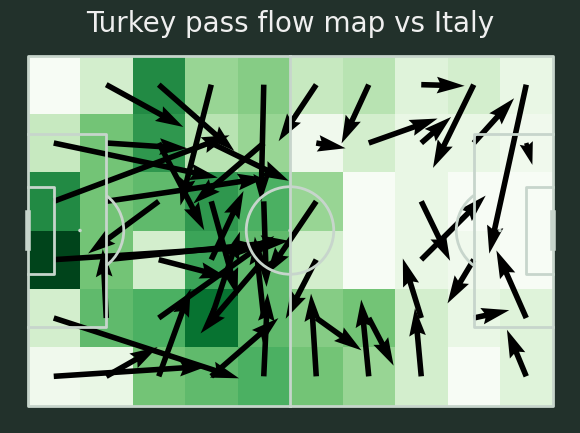

In [151]:
passflow_map(tvi_id, forpass, 'Turkey', 'Italy')

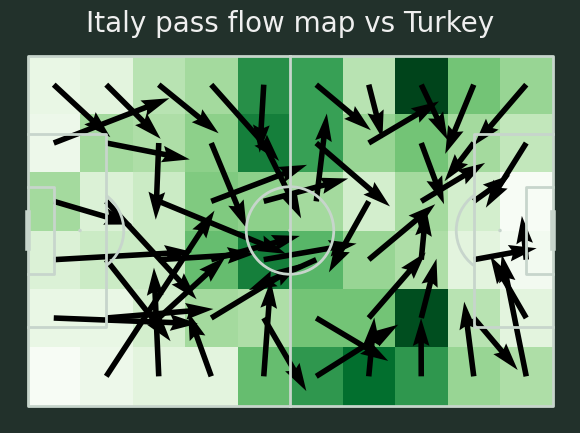

In [152]:
passflow_map(tvi_id, forpass, 'Italy', 'Turkey')

As we can see in the pass flow maps the Turkish side have mostly passed in their own defensive half, and from what we learned from the pressure map we see the Italians pressed most where the Turks passed the ball the most. Common sense.

Also when looking at the Turkish national team's pressing graph, we see Turkiye have also pressed where the Italian have passed the most.(The darker shaded areas) It's quite interesting to see an almost perfect correlation with passing frequency zones and pressing zones.

<h5> <b> Through Ball Map

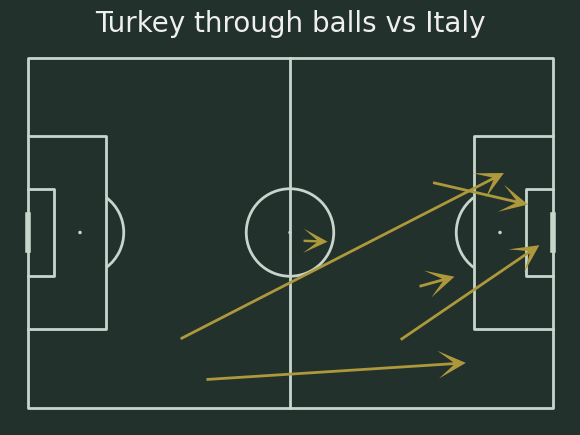

In [153]:
thruball_map(tvi_id, forthru, 'Turkey', 'Italy')

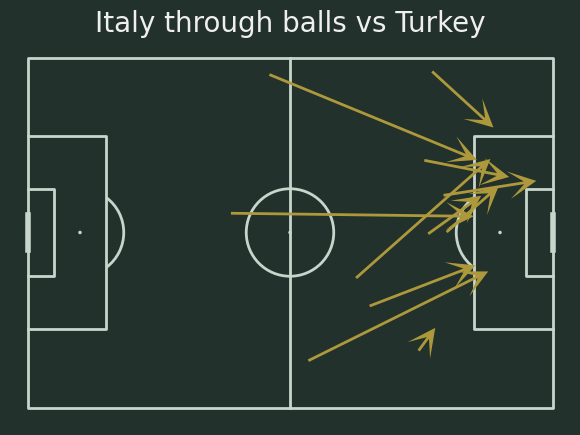

In [154]:
thruball_map(tvi_id, forthru, 'Italy', 'Turkey')

Turkey seem to have seen more openings in the right side of the pitch (Spinazzola's defensive duties), whereas Italy have found more options in the left/centre (Çelik & Soyuncu's defensive duties) side of the pitch.

<h5> <b> Duels & Dribbles Past

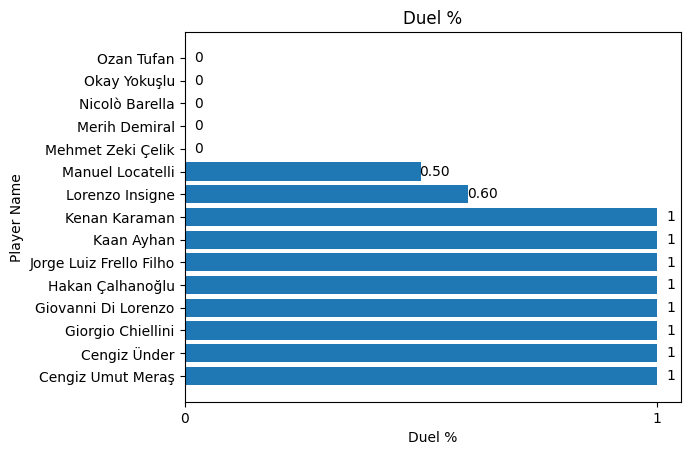

In [155]:
compare_players_plot(tvi_id, duel_per_player, 'duel_percentage', 'Duel %', False)

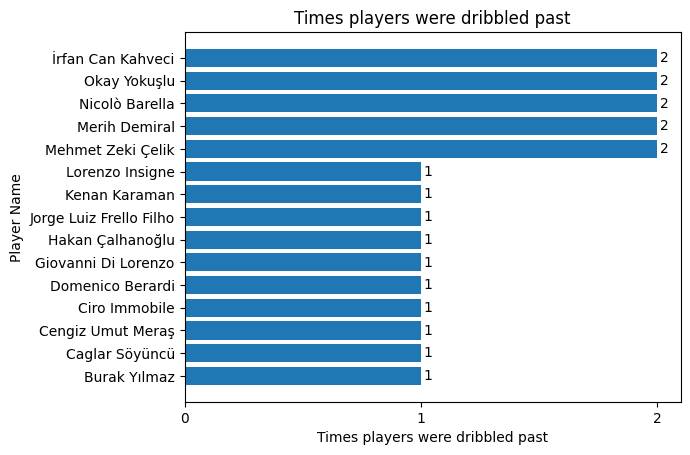

In [156]:
compare_players_plot(tvi_id, drbpast_per_player, 'type_name', 'Times players were dribbled past', True)

As seen here, 13/20 dribbled past stats belong to Turkish players. Tufan, Yokuslu, Demiral and Celik won none of their duels with their opponents. Not so coincidentally, midfielder Kahveci, CDM Yokuşlu, CB Demiral and RB Çelik were dribbled past twice by their opponents. It seems like Turkiye could not handle man-to-man attacks.

<h5> <b> Thoughts and Comments - Italy v Turkiye

1. The Italians were dominant on the ball as expected.
2. Even though the Turkish side forced the Italians to lose the ball more, and pressed more then them, it wasn't as effective as Italy's as they were mostly done in the defensive half trying to stop the Italian attacks.
3. The Italians made a difference with their counterpressing ability, trying to get the ball after they lost it much more than the Turks. This shows that the Turks' tactical understanding was on regrouping and defending when they lost the ball.
4. The Turkish side lost the ball the most in the middle of the pitch, unable to overpower the Italian midfield.
5. The Turks passed the ball more in their own half and had (proportionately) no passes in the middle of the pitch in the 3rd half of the length of the pitch. On the contrary the Italians were able to pass everywhere on the field.
6. The Turks allowed a lot of through balls to come from their right side.
7. 1v1 duels were a weak link in Turkiye's defensive plays, with their key players losing 100% of the duels they entered.

<h5> <b> What do the Turks need to get better at for their next game?

In this section I will act as a coach and try to give some ideas on what the Turkish National Team need to do better. Then when we will see if they DID do better in those departments when we look at the stats.

1. Keep possession of the ball more by pressing more.
2. When the ball is lost, counterpress and don't regroup straight away otherwise we will need to press in the defensive half.
3. Try to press a lot more higher up the pitch, otherwise we will need to park the bus like in Point 2.
4. I need to change up the midfield as our midfielders were not on form with their passing & hold up play.
5. Attack from down the middle of the pitch more, otherwise our game will be too predictable.
6. Follow your marking duties better, especially Celik and Soyuncu, otherwise we will let too many through balls in.
7. Be more technical with your 1v1 duels and think about your next move carefully otherwise you won't get the ball.

<h4> <b>Turkiye 0 - 2 Wales</b> </h4>

<b>Turkiye Squad:</b>

Uğurcan Çakır - GK

Zeki Çelik - RB

Kaan Ayhan - CB

Çağlar Söyüncü - CB

Umut Meraş - LB

Okay Yokuşlu - CDM

Kenan Karaman - RM

Ozan Tufan - CM

Hakan Çalhanoğlu - CM

Cengiz Under - LM

Burak Yılmaz - ST

Yazici and Demiral have been dropped for this match in favor of Under and Ayhan. (Demiral scored an own goal and also lost all duels in the last match. A fair choice? Maybe, but not good for the players morale.)

In [157]:
tvw_id = 3788755

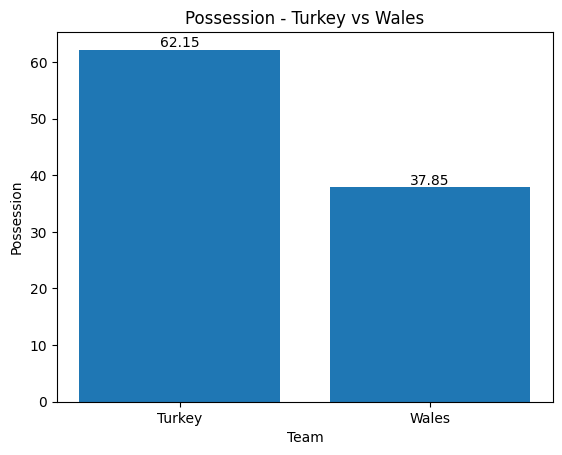

In [158]:
plot_bar(tvw_id, possession_per_match, 'possession_percentage', 'Possession')

The Turks were able to dominate the ball, contrary to the last match.

<h5> <b> xG Chart & Shots


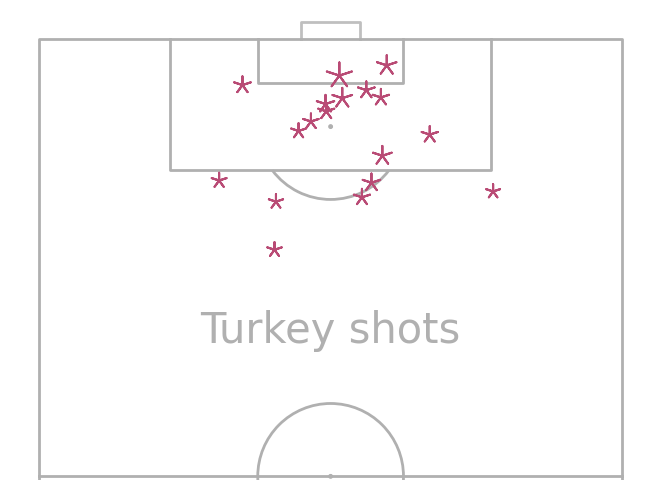

In [159]:
shotmap(tvw_id, forxg, 'Turkey')

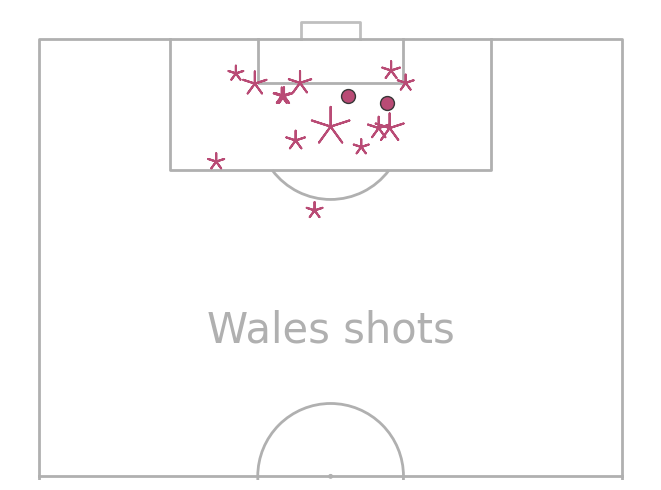

In [160]:
shotmap(tvw_id, forxg, 'Wales')

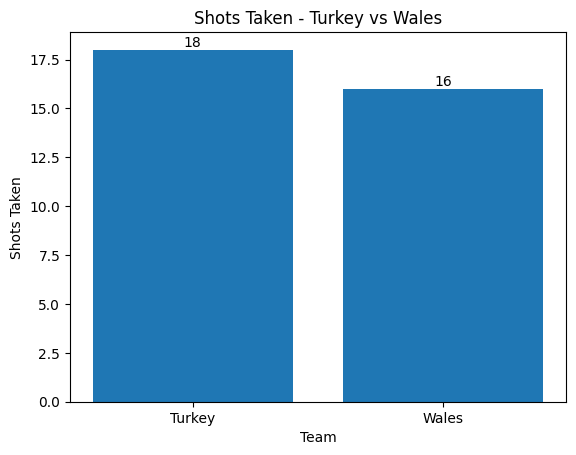

In [161]:
plot_bar(tvw_id, shot_count_by_match, 'shot_count', "Shots Taken")

In [167]:
# plot_xg_race(forxg, tvw_id, 'Turkey', 'Wales')

FIX ITTTTTTTTTTTTTT

<h5> <b> Dispossession


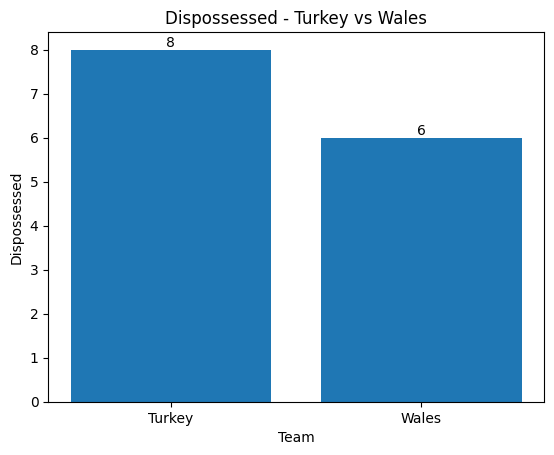

In [168]:
plot_bar(tvw_id, disp_count_by_match, 'type_name', "Dispossessed")

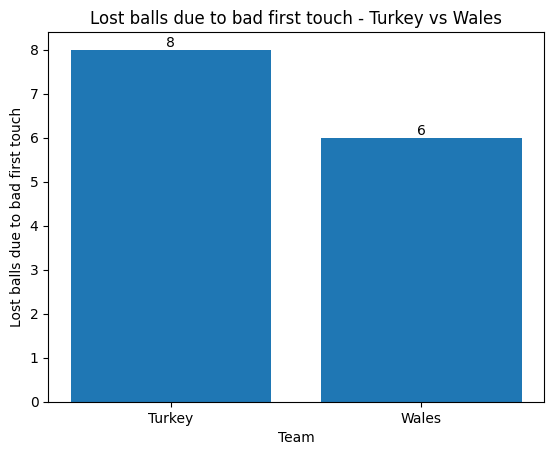

In [169]:
plot_bar(tvw_id, miscontrol_count_by_match, 'type_name', "Lost balls due to bad first touch")

Unlike the match versus Italy, the Turks have been disposessed and have lost the ball due to a bad first touch more than their opponents, although not by much. 

Turkiye manager at the time, Senol Gunes had blamed the defeat on individual mistakes in the press conference after the match. Even though Turkey have lost the ball more, these losses should not be categorised as "individual mistakes", if that really is the case.

<h5> <b> Pressures made


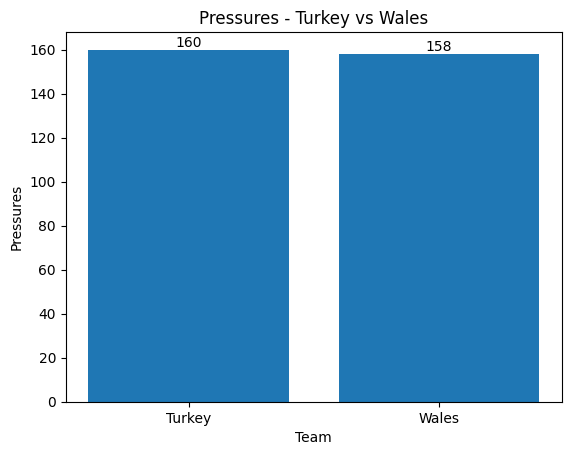

In [170]:
plot_bar(tvw_id, press_count_by_match, 'type_name', "Pressures")

This time around, pressures made are divided equally between the two team, although Turkiye have pressed a lot less than last game. Perhaps a result of dominating possession.

<h5> <b> Counterpresses


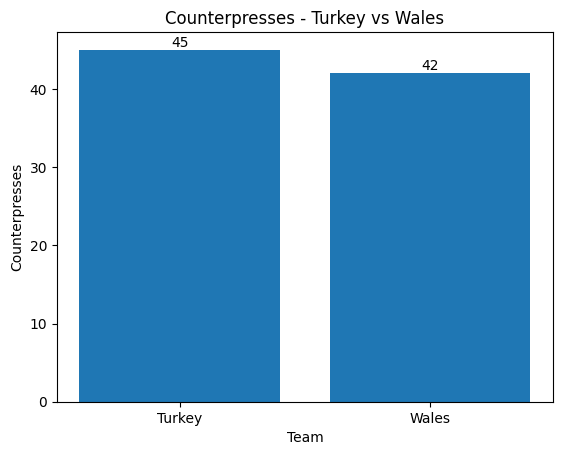

In [171]:
plot_bar(tvw_id, counterpress_count_by_match, 'counterpress', "Counterpresses")

Once again unlike last game, the Turks have counterpressed more than their opponents even though they had more of the ball. Lesson learned, perhaps.

<h5> <b> Interceptions


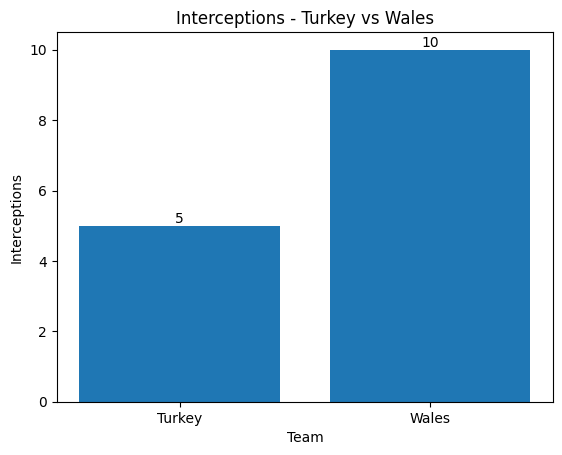

In [172]:
plot_bar(tvw_id, interception_count_by_match, 'type_name', "Interceptions")

This time the Turks look like they've misplaced quite a few passes compared to their opponents. Less than they did in the last game, but comparatively worse. Let's see where both teams lost the ball due to interceptions, dispossessions and bad first touches.

<h5> <b> Zones of Ball Loss


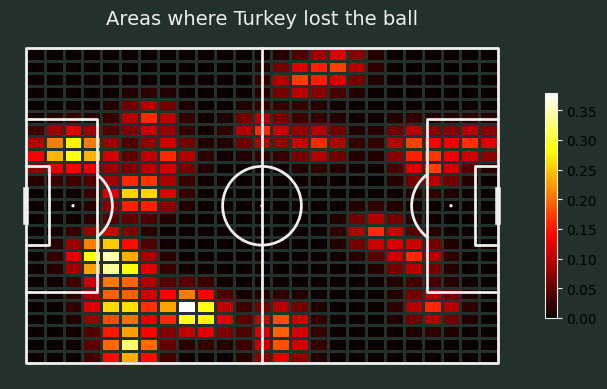

In [173]:
heatmap_gaussian(tvw_id, ball_loss, 'Turkey', 'lost the ball')

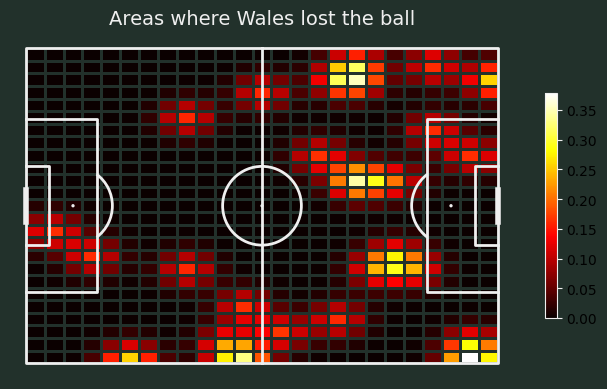

In [174]:
heatmap_gaussian(tvw_id, ball_loss, 'Wales', 'lost the ball')

An 'aha' moment in this analysis comes here. As seen on the heatmaps, the Welsh team have lost the ball upfront on attack, while the Turks have lost in on defense. (Especially on the right side of their pitch)

Celik at right back seems to be a culprit here, just like last game.

Let's see if the zones of pressing and counterpressing correlate with the possession loss heatmap once again.

<h5> <b> Zones of Press & Counterpress

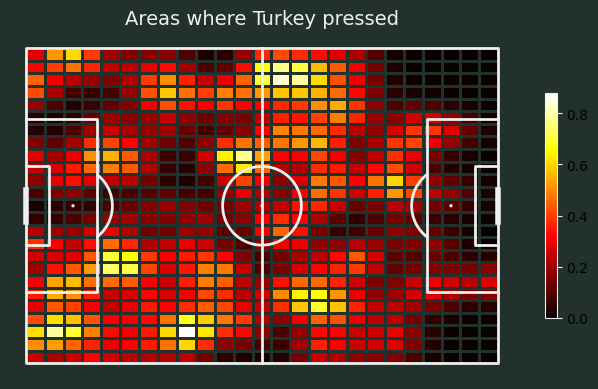

In [175]:
heatmap_gaussian(tvw_id, forpress, 'Turkey', 'pressed')

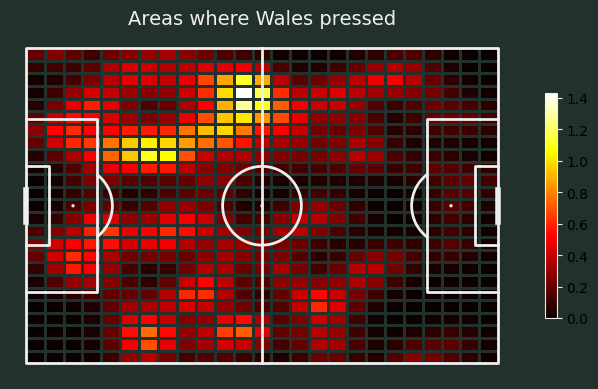

In [176]:
heatmap_gaussian(tvw_id, forpress, 'Wales', 'pressed')

This time around Turkiye seem to have pressed all around the field, except the opposition's box. There also seems to be a diagonal pressing zone from the right back to left winger position.

For Wales, we don't see the same distribution in press, they have pressed mostly on the left side of their defensive line and midfield.

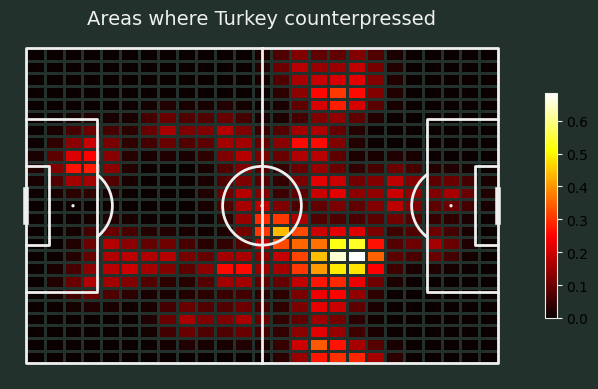

In [177]:
heatmap_gaussian(tvw_id, forcntrprs, 'Turkey', 'counterpressed')

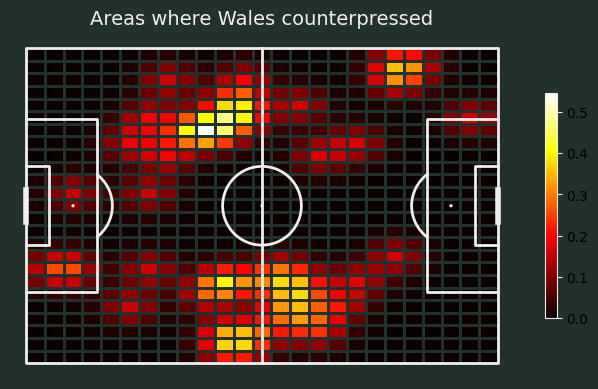

In [178]:
heatmap_gaussian(tvw_id, forcntrprs, 'Wales', 'counterpressed')

Wales have counterpressed more one the wings while the Turkish side have pressed more just infront the midway line.

The heatmaps show us Turkiye being more dominant on and off the ball, but have lost the ball in critical locations, possibly leading to the scoreline. Let's continue.

<h5> <b> Pass Flow Map

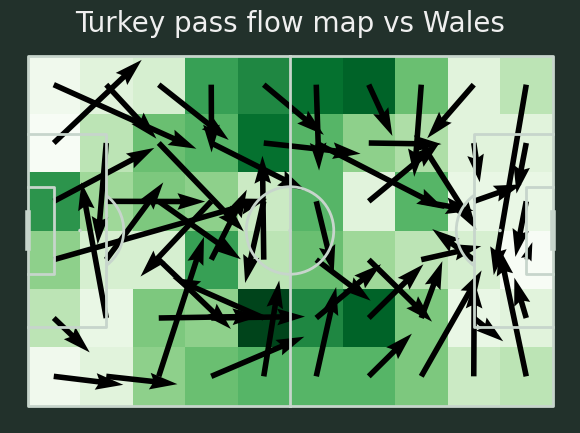

In [179]:
passflow_map(tvw_id, forpass, 'Turkey', 'Wales')

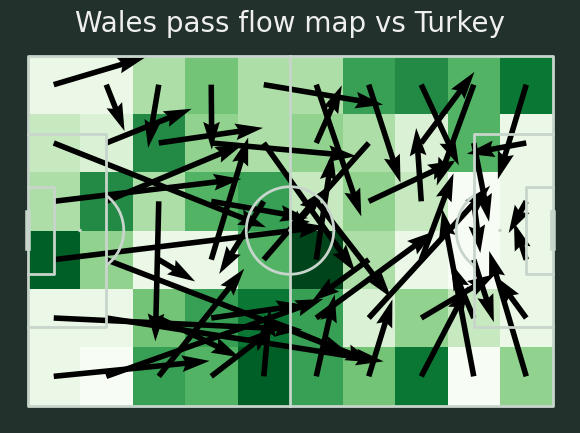

In [180]:
passflow_map(tvw_id, forpass, 'Wales', 'Turkey')

Turkiye's passing has a more general distribution in this match, but once again have low concentration in the middle of the pitch. A weak middle zone might have hurt Turkiye in this game.

The Welsh have complete control in the midfield (seen with very dark shades in the middle) and have utilized the right wing a lot. They seem to have used Gareth Bale as a main attacking outlet.

<h5> <b> Through Ball Map

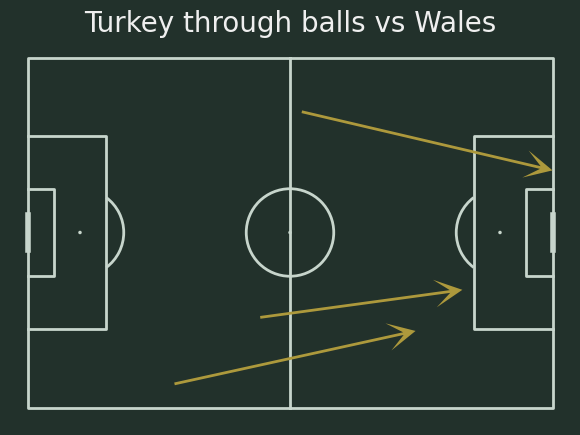

In [181]:
thruball_map(tvw_id, forthru, 'Turkey', 'Wales')

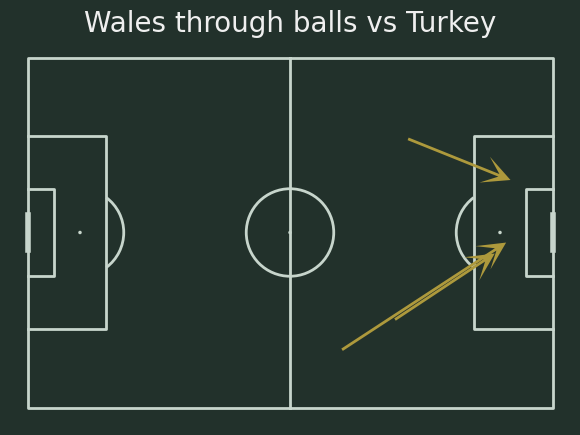

In [182]:
thruball_map(tvw_id, forthru, 'Wales', 'Turkey')

A very little number of through balls have occured in this match. The only thing to take note of might be that Wales have made 2 long through balls from the right side of the pitch. (The longer one was an assist by Gareth Bale)

<h5> <b> Duels & Dribbles Past

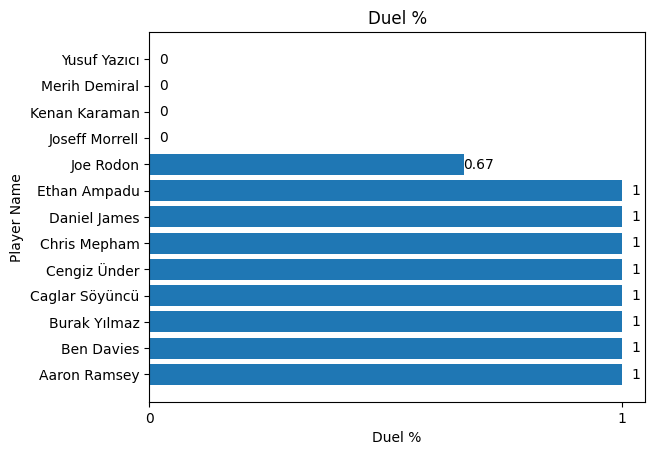

In [183]:
compare_players_plot(tvw_id, duel_per_player, 'duel_percentage', 'Duel %', False)

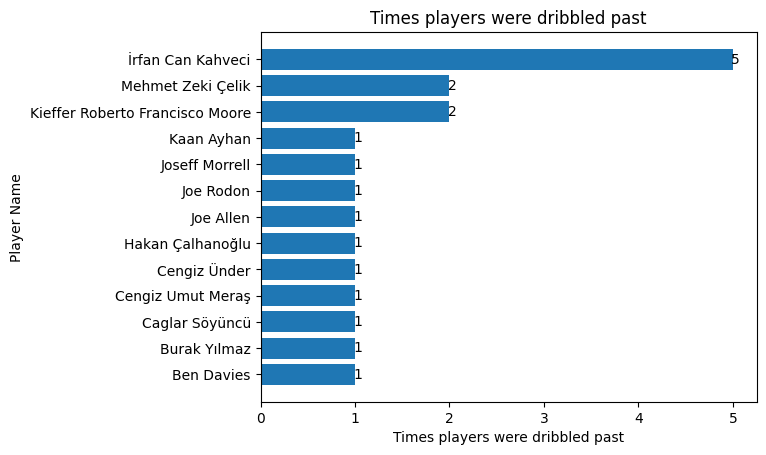

In [184]:
compare_players_plot(tvw_id, drbpast_per_player, 'type_name', 'Times players were dribbled past', True)

Defender Demiral (subbed on), midfielder Yazici (subbed on) and winger Karaman lost all duels against their opponents. Another tough game for Demiral as he so far has 2 0% duel games in 2 games.

Midfielder Kahveci was dribbled past 5 times during this game, an interesting stats as he was subbed on in the 83rd minute of the game.

Right back Celik also had another bad game as he was dribbled past twice once more.

<h5> <b> Thoughts and Comments - Turkiye v Wales

1. The Turks were dominant on the ball. 
2. Even though the Turks lost the ball a little bit more, they recorded a high number of counterpresses.
3. The amount of intercepted balls might have downed Turkiye players' morale.
4. The Turkish side lost the ball the most where their defensive line is.
5. Pressured made were more distributed than last game.
6. Turkiye once again failed to utilize the middle of the pitch.
7. Necessary precautions weren't taken for Gareth Bale, a proficient performer for his national team.
8. Players that were substituted on were cold and uneffective.

<h5> <b> Lesson learned?

- [x] Keep possession of the ball more by pressing more 
- [x] When the ball is lost, counterpress and don't regroup straight away otherwise we will need to press in the defensive half. 
- [ ] Try to press a lot more higher up the pitch, otherwise we will need to park the bus like in Point 2. 
- [x] I need to change up the midfield as our midfielders were not on form with their passing & hold up play. 
- [ ] Attack from down the middle of the pitch more, otherwise our game will be too predictable. 
- [ ] Follow your marking duties better, especially Celik and Soyuncu, otherwise we will let too many through balls in. 
- [ ] Be more technical with your 1v1 duels and think about your next move carefully otherwise you won't get the ball. 

3/7

<h5> <b> What do the Turks need to get better at for their next game?

1. Press higher up the pitch, get closer to the opponent's box.
2. Stop playing out of the defense as we've lost the ball there the most.
3. Utilize the middle of the pitch more.
4. Follow your marking duties better, we have lost 2 games because of the way we mark.
5. Get better at dueling.
6. I need to make sure players are warm and used to the ball before subbing them on.

<h4> <b>Switzerland 3 - 1 Turkiye</b> </h4>

<b>Turkiye Squad:</b>

Uğurcan Çakır - GK

Zeki Çelik - RB

Merih Demiral - CB

Çağlar Söyüncü - CB

Mert Muldur - LB

Kaan Ayhan - CDM

Cengiz Under - RM

Ozan Tufan - CM

Irfan Can Kahveci - CM

Hakan Çalhanoğlu - LM

Burak Yılmaz - ST

Meras, Yokuslu, Karaman have been dropped in favor of Muldur, Ayhan and Kahveci. Ayhan has moved from CB to CDM.

An interesting move from Gunes as Demiral and Kahveci were both out of form last game. Celik who has been in poor form hasn't been dropped and instead Meras who had an OK 2nd game has been dropped.

The most striking difference to me has been Kahveci's inclusion in the 11. He was dribbled past 5 times in 12 minutes, the most in the lsat game.

In [190]:
tvs_id = 3788765

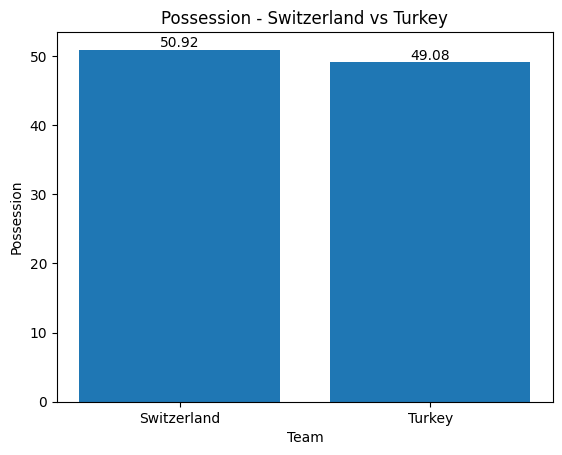

In [191]:
plot_bar(tvs_id, possession_per_match, 'possession_percentage', 'Possession')

Equally distributed possession stats tell us that neither team was able to hold the ball for the majority of the game.

<h5> <b> xG Chart & Shots


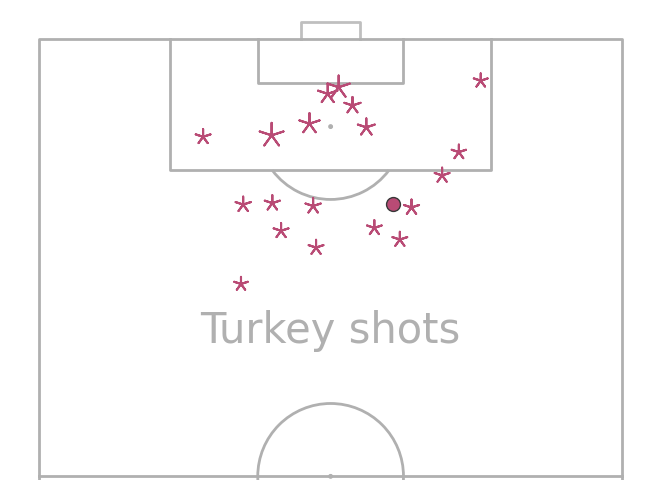

In [192]:
shotmap(tvs_id, forxg, 'Turkey')

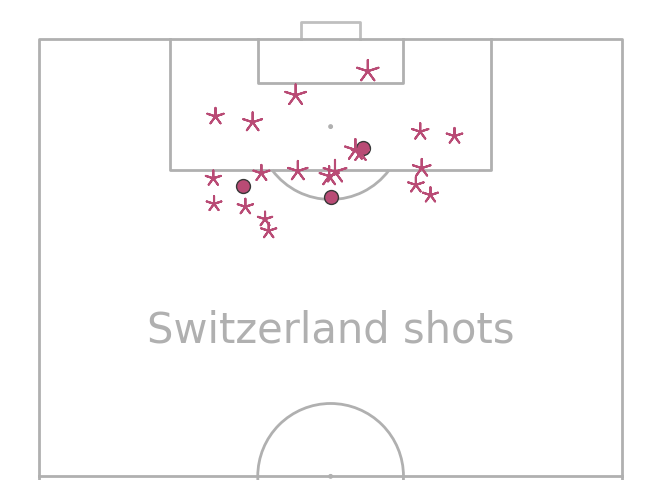

In [213]:
shotmap(tvs_id, forxg, 'Switzerland')

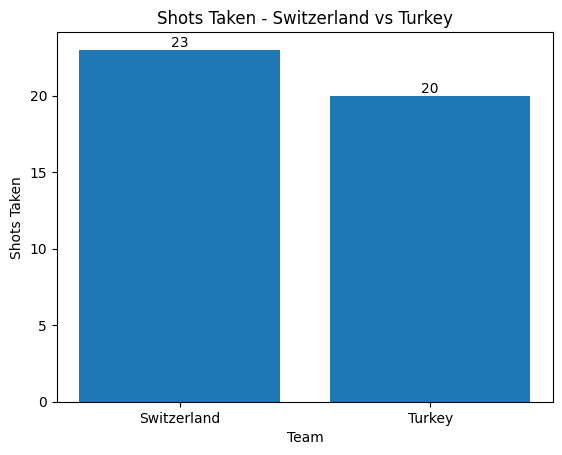

In [193]:
plot_bar(tvs_id, shot_count_by_match, 'shot_count', "Shots Taken")

In [ ]:
# plot_xg_race(forxg, tvw_id, 'Turkey', 'Wales')

FIX ITTTTTTTTTTTTTT

<h5> <b> Dispossession


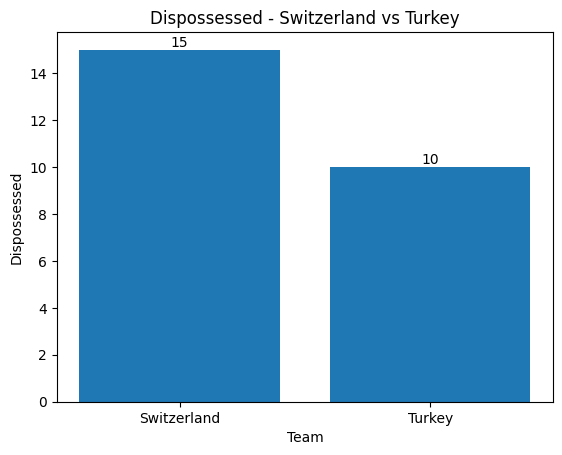

In [194]:
plot_bar(tvs_id, disp_count_by_match, 'type_name', "Dispossessed")

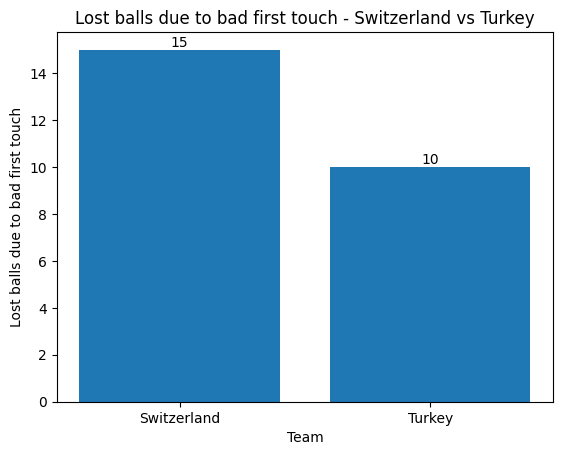

In [195]:
plot_bar(tvs_id, miscontrol_count_by_match, 'type_name', "Lost balls due to bad first touch")

Unlike the last game against Wales, the Turks managed to lose the ball less than their opponents, even though they did lose it more in total.

<h5> <b> Pressures made


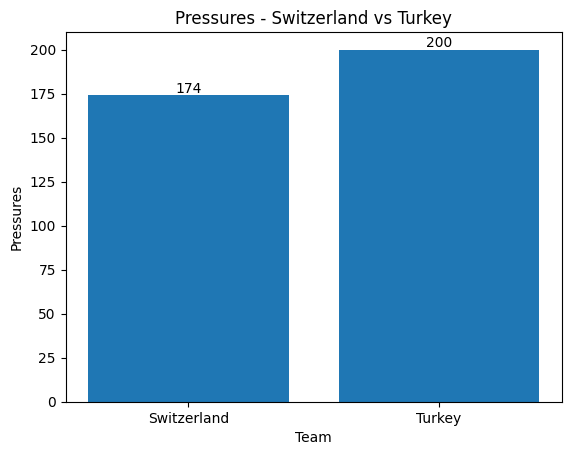

In [196]:
plot_bar(tvs_id, press_count_by_match, 'type_name', "Pressures")

Turkiye have come out with more pressing power in this last game in the group stages, perhaps a last gasp to get out of the group.

<h5> <b> Counterpresses


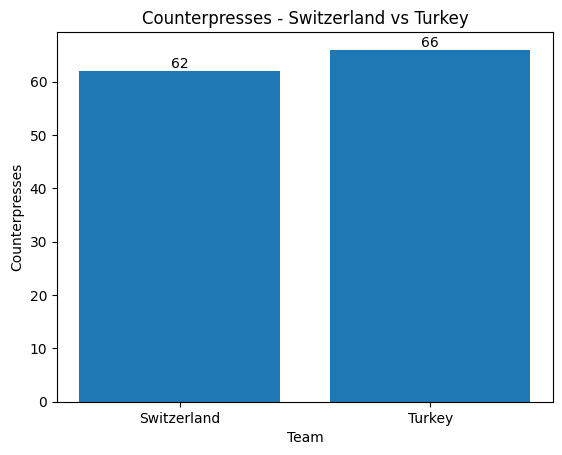

In [197]:
plot_bar(tvs_id, counterpress_count_by_match, 'counterpress', "Counterpresses")

Counterpresses are distributed equally this time around.

<h5> <b> Interceptions


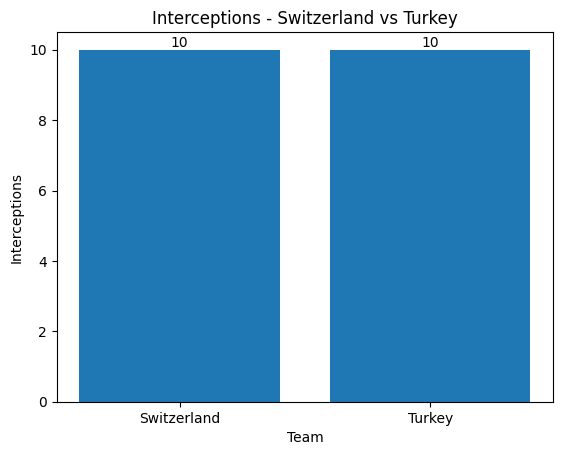

In [198]:
plot_bar(tvs_id, interception_count_by_match, 'type_name', "Interceptions")

Both sides have intercepted the ball the same amount of times, pointing at how close this game was in terms of ball control.

<h5> <b> Zones of Ball Loss


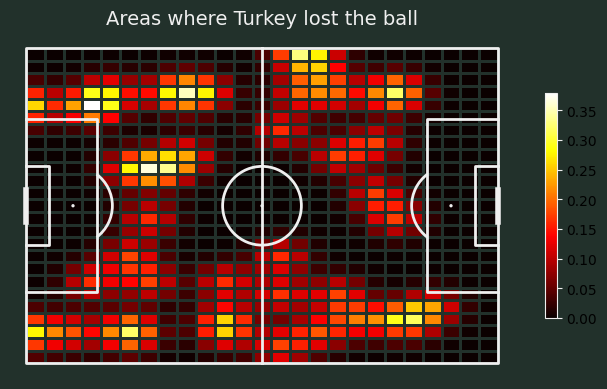

In [199]:
heatmap_gaussian(tvs_id, ball_loss, 'Turkey', 'lost the ball')

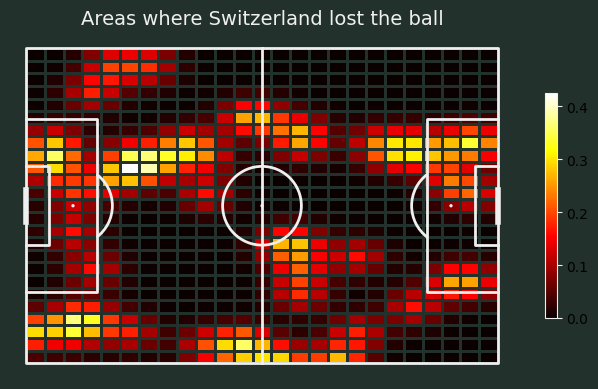

In [201]:
heatmap_gaussian(tvs_id, ball_loss, 'Switzerland', 'lost the ball')

Unlike the last 2 games, zones of ball loss doesn't give us a clear picture of the reasons for defeat.

While the Turks have lost the ball more on the wing, the Swiss team seems to have a straight line down the middle where they have lost the ball (also on the right side of the pitch). Though for both sides, ball loss seems pretty distributed adding to the fact that this was a tight contest for ball retention.

Let's see if the zones of pressing and counterpressing correlate with the possession loss heatmap.

<h5> <b> Zones of Press & Counterpress

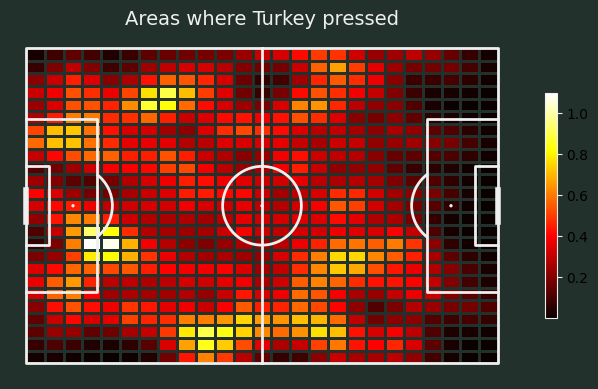

In [202]:
heatmap_gaussian(tvs_id, forpress, 'Turkey', 'pressed')

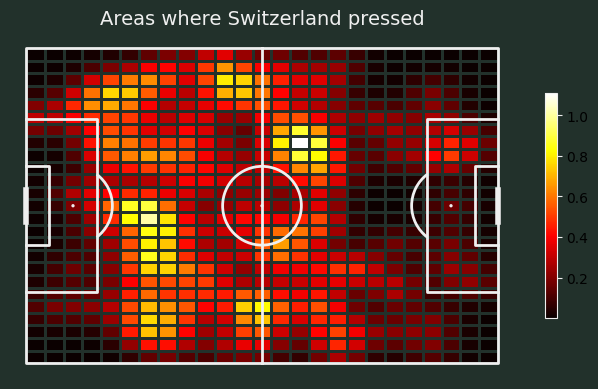

In [203]:
heatmap_gaussian(tvs_id, forpress, 'Switzerland', 'pressed')

We see distributed pressing for both sides. Turkiye seems to have been able to press a little bit more towards the Swiss box, though there isn't too much improvement in that area.

The wings have been the most frequent pressing locations for the Turkish side.

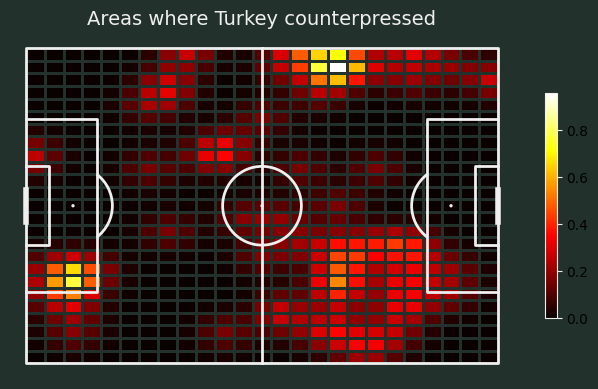

In [204]:
heatmap_gaussian(tvs_id, forcntrprs, 'Turkey', 'counterpressed')

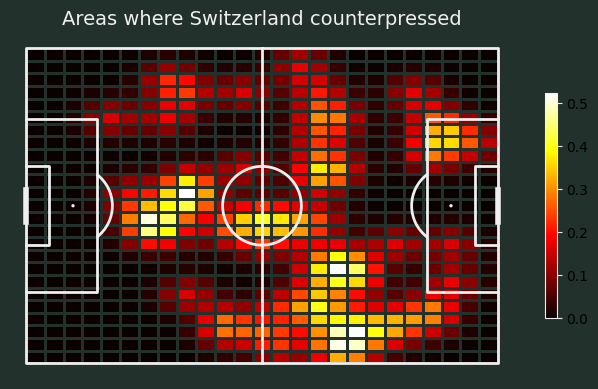

In [206]:
heatmap_gaussian(tvs_id, forcntrprs, 'Switzerland', 'counterpressed')

<h5> <b> Pass Flow Map

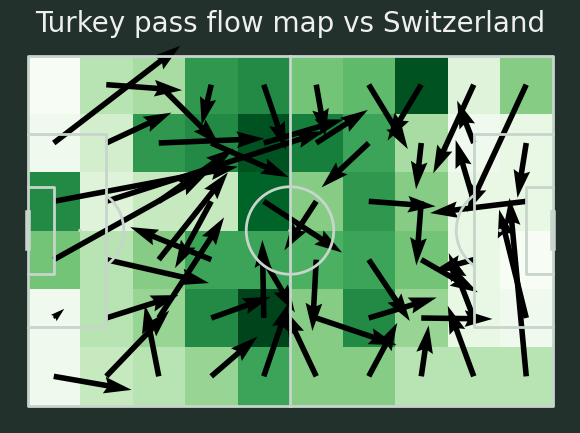

In [207]:
passflow_map(tvs_id, forpass, 'Turkey', 'Switzerland')

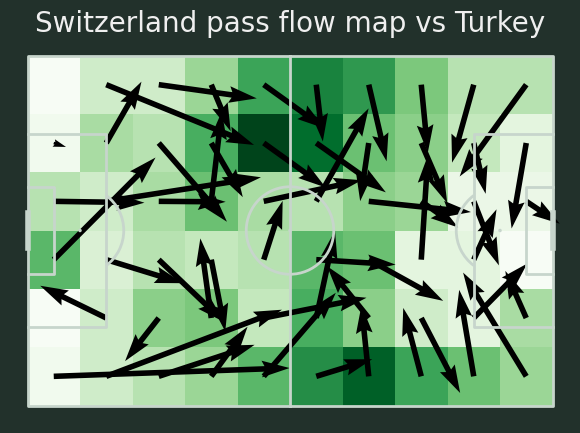

In [208]:
passflow_map(tvs_id, forpass, 'Switzerland', 'Turkey')

We see Turkiye has utilized the middle of the pitch a bit more, but has a lower frequency of passes on the right side of the pitch. We also see a lot more long balls in Turkiye's map in this game.

This time the Swiss team haven't used the middle of the pitch and instead used the wings to attack.

<h5> <b> Through Ball Map

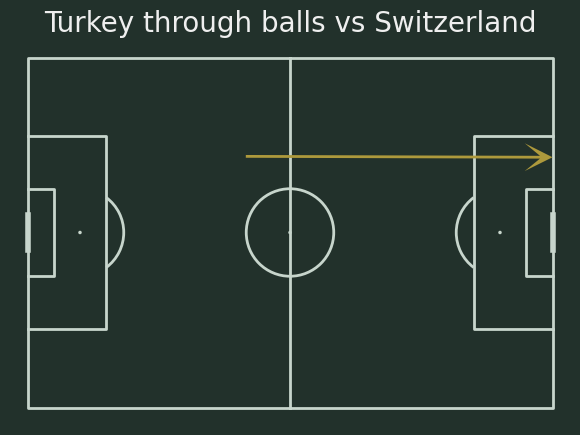

In [209]:
thruball_map(tvs_id, forthru, 'Turkey', 'Switzerland')

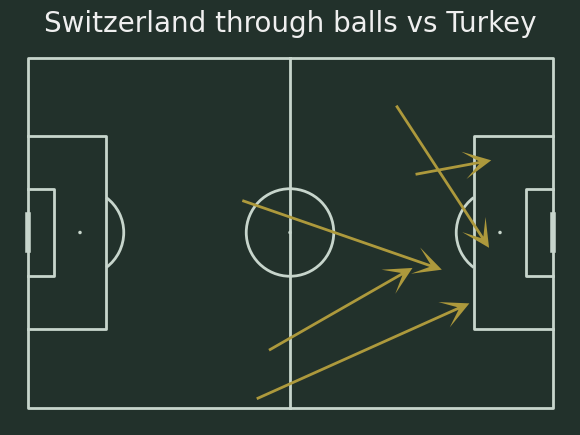

In [210]:
thruball_map(tvs_id, forthru, 'Switzerland', 'Turkey')

Turkish players have only tried 1 through ball in the entire match, while the Swiss have tried exploiting space on the defenders on Turkey's left side (Muldur and Demiral).

<h5> <b> Duels & Dribbles Past

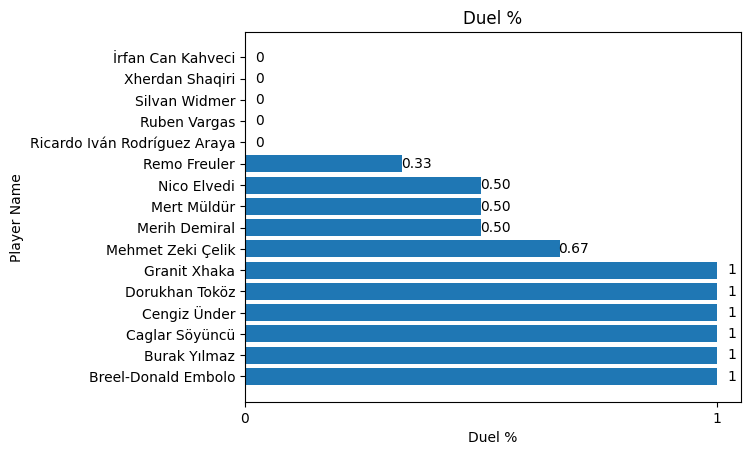

In [211]:
compare_players_plot(tvs_id, duel_per_player, 'duel_percentage', 'Duel %', False)

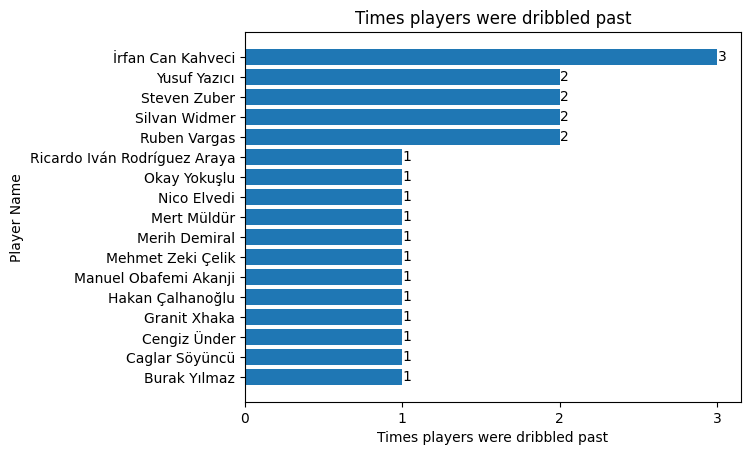

In [212]:
compare_players_plot(tvs_id, drbpast_per_player, 'type_name', 'Times players were dribbled past', True)

Once again we see midfielder Kahveci top the list of worst duelers and dribbling defenders. Even with a goal in this game, he has disappointed his team with his defensive performance once again.

We also see 4 Swiss players with 0% duel, interesting to see someone who's known for their strength and speed, Xherdan Shaqiri, win none of his duels in this game.

Muldur, Demiral and Celik won 50%, 50% and 67% of their duels respectively. A mediocre performance from the three players.

<h5> <b> Thoughts and Comments - Switzerland v Turkiye

1. It was a tight game between the two teams. Both teams gave it their all to hold on to the ball and win it back.
2. Once again, good pressing from the Turkish team.
3. Turkiye was able to utilize the space in the middle of the pitch this time.
4. The Turks were unable to utilize the left wing as much as they did in the last game, most probably leaving Under out of the game.
5. A bad starting 11 led to a bad result. Out of form players continued to be out of form.
6. Turkiye dueled better than they usually do, but it was not enough.
7. Once again, marking duties were not done properly. One of the through balls led to a goal.

<h5> <b> Lesson learned?

- [x] Press higher up the pitch, get closer to the opponent's box.
- [ ] Stop playing out of the defense as we've lost the ball there the most.
- [x] Utilize the middle of the pitch more.
- [ ] Follow your marking duties better, we have lost 2 games because of the way we mark.
- [x] Get better at dueling. 
- [ ] I need to make sure players are warm and used to the ball before subbing them on. 


3/6

<h2> Summary </h2>

<h5> <b> Tactical Standpoint

When looking at the data and visualizations wholistically, there are 2 things that I would like to take note of.

<b>1. Inconsistency:</b> 

Turkiye were inconsistent on and off the ball.         Hypothetically, in one game they might lose the ball 100 times, then 10 times in the next game, then 50 times in the one after.

One game they might press well, the next game they might press very poorly. One game they might utilize the wings well, the other game they might completely forget the wings exist.

Tactical inconsistency, even if it's for the better, will hurt the chances of a team. They might've been unpredictable for their opponents, but by playing so inconsistently they were also unpredictable for themselves.


<b>2. Lack of taking a lesson:</b> 

Turkiye insisted on:

    a. Not pressing up front
    b. Not utilizing the middle of the pitch
    c. Not getting better at dueling
    d. Not getting better at man-marking 

These 2 factors, I believe, were the main culprits of their failure from a tactical standpoint.

<h5> <b> Psychological Standpoint

From a spectator's viewpoint, the things that made Turkiye's campaign one-to-forget cannot be explained solely with stats and tactics. 

<b>Expectations</b>

As mentioned before, Turkiye were seen as dark horses entering this tournament. Players like Soyuncu, Demiral, Celik, Calhanoglu, Under had been playing for top European clubs for some time and were counted on by Turkish and foreign fans alike.

After qualifying for the group stage after a strong showing in the qualifiers, many fans were tipping Turkiye to win it all. 

These expectations grew in the press and social media, resulting on immense pressure being put on the national team players. Come game time, the tenaciousness shown from the Turkish side was a sight to behold. Shaky legs, misplaced passes, passing around the back... It seemed too much for the Turkish players, and they came back with a 3-0 loss in their first game.

<b>Coaching</b>

I believe Turkiye manager Senol Gunes didn't have the right mindset and was not able to control his players when they needed him. In foreign press, Gunes was also ridiculed for taking notes in the last few minutes of the game against Italy instead of controlling his players.

<h5> <b> Were my initial thoughts right?

At the beginning of our analysis, I said:

1. The mental drop turned into simple mistakes, misplaced passes, low % in duels, a collective loss of cohesion.
2. The team seemed to lack a tactical understanding, something that was pointed out by a minority during the qualifying stages.
3. Running distance and pressures seemed to lack, lost balls weren't being chased after, causing the opposing teams to assert dominance on the field.


I believe point 1 and 2 are correct. The stats show high numbers of misplaced passes and low % in duels while also highlighting tactical inconsistencies.

I was mistaken on point 3, pressing frequency was high from the Turkish side, but the pressing style wasn't what the team needed.

<b> Thank you for participating in this analysis :)